In [5]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method

Using device: cpu
Files already downloaded and verified
Loaded 1000 test images.
Loading cifar10_resnet20 model from Torch Hub...


Using cache found in C:\Users\mtm30/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Model wrapped in ART PyTorchClassifier.

Generating adversarial examples using FGSM...
Generating adversarial examples using PGD...


Generating adversarial examples using Carlini & Wagner (L2)...


C&W L_2: 100%|██████████| 200/200 [1:23:08<00:00, 24.94s/it]


Adversarial examples generated.

Evaluating model performance:
Accuracy on clean examples: 91.70%
Accuracy on FGSM adversarial examples: 18.90%
Accuracy on PGD adversarial examples: 4.30%
Accuracy on C&W adversarial examples: 29.50%

=== SUMMARY OF RESULTS ===
Model: cifar10_resnet20
Clean Accuracy: 91.70%
FGSM Attack Accuracy: 18.90%
PGD Attack Accuracy: 4.30%
C&W Attack Accuracy: 29.50%


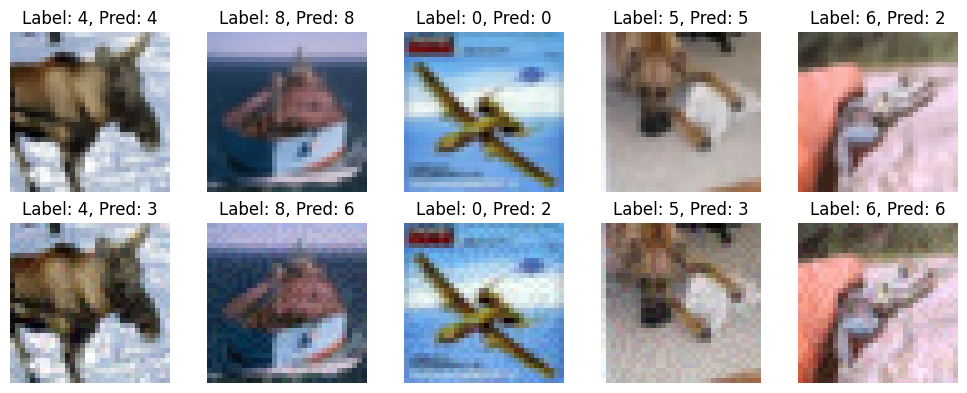

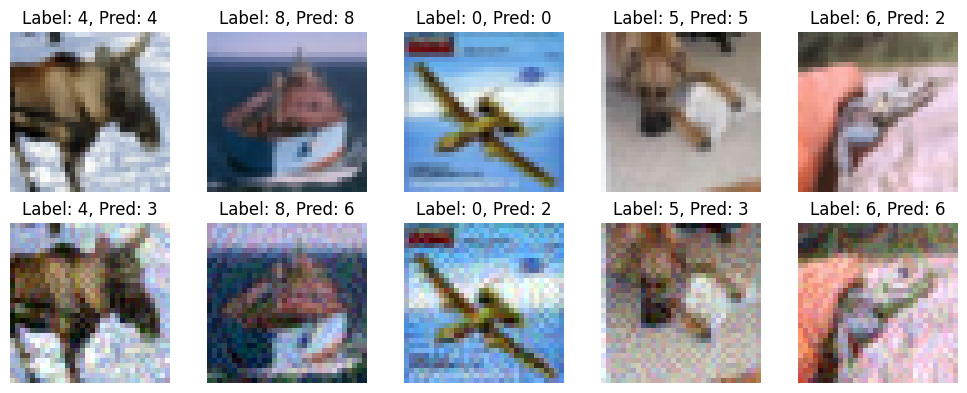

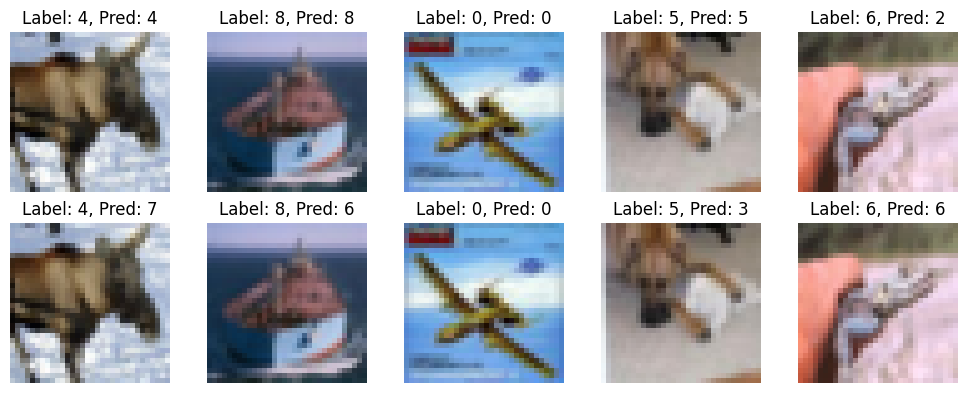

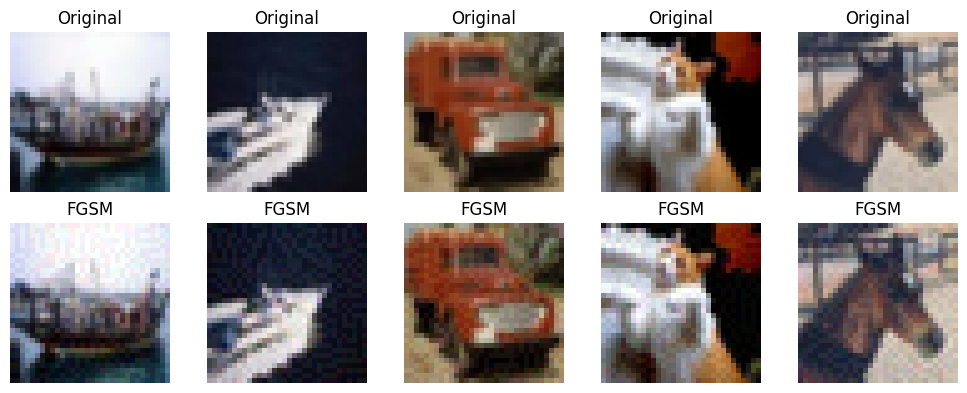

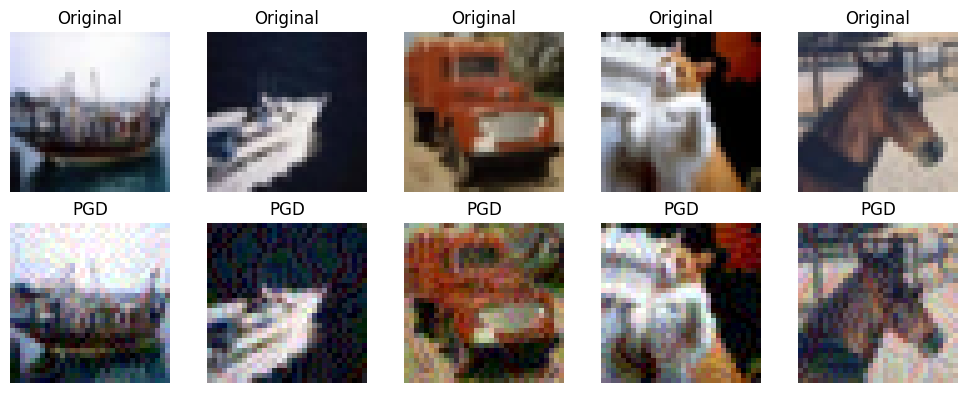

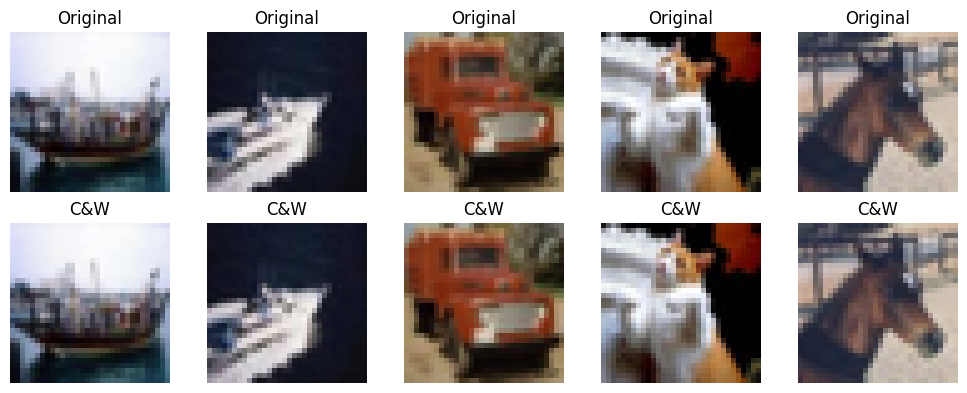

In [6]:


# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

#####################################
#           CONFIGURATION           
#####################################
model_name = "resnet20"  
# Possible values from chenyaofo/pytorch-cifar-models for CIFAR-10 include:
# - "cifar10_resnet20"
# - "cifar10_vgg16_bn"
# To switch to VGG16, set model_name = "vgg16_bn"

attack_batch_size = 200   # Batch size for generating adversarial examples
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

print("Using device:", device)

#####################################
#          DATA LOADING
#####################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # Mean for CIFAR-10
        (0.2470, 0.2435, 0.2616)   # Std for CIFAR-10
    )
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
print(f"Loaded {len(images)} test images.")

classes = test_dataset.classes

#####################################
#        MODEL LOADING
#####################################
# Load the chosen model from Torch Hub
if model_name == "resnet20":
    hub_model_name = 'cifar10_resnet20'
elif model_name == "vgg16_bn":
    hub_model_name = 'cifar10_vgg16_bn'
else:
    raise ValueError("Unsupported model name. Use 'resnet20' or 'vgg16_bn' for CIFAR-10.")

print(f"Loading {hub_model_name} model from Torch Hub...")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', hub_model_name, pretrained=True)
model.to(device)
model.eval()

#####################################
#       ART CLASSIFIER WRAPPER
#####################################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

classifier_resnet = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

print("Model wrapped in ART PyTorchClassifier.")

#####################################
#        ATTACK DEFINITIONS
#####################################
# FGSM attack
attack_fgsm_resnet20 = FastGradientMethod(estimator=classifier_resnet, eps=0.1)

# PGD attack
attack_pgd_resnet20 = ProjectedGradientDescent(estimator=classifier_resnet, eps=0.3, eps_step=0.1, max_iter=40)

# C&W attack: Reduced parameters to avoid extremely long runtimes
attack_cw_resnet20 = CarliniL2Method(
    classifier=classifier_resnet,
    max_iter=200,            # Reduce from 1000
    binary_search_steps=3,   # Reduce from 9
    confidence=0
)

#####################################
#     ADVERSARIAL EXAMPLE GENERATION
#####################################
def generate_adversarial_examples(attack, x_data, batch_size=200):
    """
    Generate adversarial examples in batches to prevent excessive runtime and memory issues.
    """
    adv_examples = []
    x_data_np = x_data.cpu().numpy()
    n = len(x_data_np)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch = x_data_np[start:end]
        adv = attack.generate(x=batch)
        adv_examples.append(adv)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples

print("\nGenerating adversarial examples using FGSM...")
x_test_adv_fgsm_resnet20 = attack_fgsm_resnet20.generate(x=images.cpu().numpy())

print("Generating adversarial examples using PGD...")
x_test_adv_pgd_resnet20 = attack_pgd_resnet20.generate(x=images.cpu().numpy())

print("Generating adversarial examples using Carlini & Wagner (L2)...")
x_test_adv_cw_resnet20 = generate_adversarial_examples(attack_cw_resnet20, images, batch_size=attack_batch_size)

print("Adversarial examples generated.")

#####################################
#        EVALUATION FUNCTIONS
#####################################
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    accuracy = np.mean(preds_labels == y)
    return accuracy

#####################################
#        EVALUATE MODEL
#####################################
y_true = labels.cpu().numpy()

print("\nEvaluating model performance:")
acc_clean_resnet20 = evaluate_accuracy(classifier_resnet, images.cpu().numpy(), y_true)
print(f"Accuracy on clean examples: {acc_clean_resnet20 * 100:.2f}%")

acc_fgsm_resnet20 = evaluate_accuracy(classifier_resnet, x_test_adv_fgsm_resnet20, y_true)
print(f"Accuracy on FGSM adversarial examples: {acc_fgsm_resnet20 * 100:.2f}%")

acc_pgd_resnet20 = evaluate_accuracy(classifier_resnet, x_test_adv_pgd_resnet20, y_true)
print(f"Accuracy on PGD adversarial examples: {acc_pgd_resnet20 * 100:.2f}%")

acc_cw_resnet20  = evaluate_accuracy(classifier_resnet, x_test_adv_cw_resnet20, y_true)
print(f"Accuracy on C&W adversarial examples: {acc_cw_resnet20 * 100:.2f}%")

# Save them to .npy files, to use later on
np.save("attack_fgsm_resnet20.npy", attack_fgsm_resnet20)
np.save("attack_pgd_resnet20.npy", attack_pgd_resnet20)
np.save("attack_cw_resnet20.npy", attack_cw_resnet20)
np.save("x_test_adv_fgsm_resnet20.npy", x_test_adv_fgsm_resnet20)
np.save("x_test_adv_pgd_resnet20.npy", x_test_adv_pgd_resnet20)
np.save("x_test_adv_cw_resnet20.npy", x_test_adv_cw_resnet20)

#####################################
#        SUMMARY
#####################################
print("\n=== SUMMARY OF RESULTS ===")
print(f"Model: {hub_model_name}")
print(f"Clean Accuracy: {acc_clean_resnet20 * 100:.2f}%")
print(f"FGSM Attack Accuracy: {acc_fgsm_resnet20 * 100:.2f}%")
print(f"PGD Attack Accuracy: {acc_pgd_resnet20 * 100:.2f}%")
print(f"C&W Attack Accuracy: {acc_cw_resnet20 * 100:.2f}%")

#####################################
#        OPTIONAL VISUALIZATION
#####################################
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img * std.reshape(3,1,1) + mean.reshape(3,1,1)
    return np.clip(img, 0, 1)

def plot_adversarial_examples(original, adv, title,
                              num_examples=5,
                              labels_orig=None, 
                              preds_orig=None,
                              preds_adv=None):
    plt.figure(figsize=(10, 4))
    for i in range(num_examples):
        # Original Image
        plt.subplot(2, num_examples, i+1)
        plt.imshow(np.transpose(denormalize(original[i]), (1, 2, 0)))
        # If we have labels & predictions, show them
        if labels_orig is not None and preds_orig is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_orig[i]}")
        else:
            plt.title("Original")
        plt.axis('off')

        # Adversarial Image
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(np.transpose(denormalize(adv[i]), (1, 2, 0)))
        # If we have original labels & adv predictions, show them
        if labels_orig is not None and preds_adv is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_adv[i]}")
        else:
            plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few examples
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]

# Get subset of true labels for these indices
y_subset = y_true[indices]

# Predict on the original subset
preds_original = classifier_resnet.predict(x_original)
preds_original_labels = np.argmax(preds_original, axis=1)

# 1) FGSM
x_fgsm_resnet20 = x_test_adv_fgsm_resnet20[indices]
preds_fgsm = classifier_resnet.predict(x_fgsm_resnet20)
preds_fgsm_labels = np.argmax(preds_fgsm, axis=1)
plot_adversarial_examples(x_original, 
                          x_fgsm_resnet20,
                          "FGSM",
                          num_examples=num_show,
                          labels_orig=y_subset, 
                          preds_orig=preds_original_labels,
                          preds_adv=preds_fgsm_labels)

# 2) PGD
x_pgd_resnet20 = x_test_adv_pgd_resnet20[indices]
preds_pgd = classifier_resnet.predict(x_pgd_resnet20)
preds_pgd_labels = np.argmax(preds_pgd, axis=1)
plot_adversarial_examples(x_original, 
                          x_pgd_resnet20,
                          "PGD",
                          num_examples=num_show,
                          labels_orig=y_subset, 
                          preds_orig=preds_original_labels,
                          preds_adv=preds_pgd_labels)

# 3) C&W
x_cw_resnet20 = x_test_adv_cw_resnet20[indices]
preds_cw = classifier_resnet.predict(x_cw_resnet20)
preds_cw_labels = np.argmax(preds_cw, axis=1)
plot_adversarial_examples(x_original, 
                          x_cw_resnet20,
                          "C&W",
                          num_examples=num_show,
                          labels_orig=y_subset, 
                          preds_orig=preds_original_labels,
                          preds_adv=preds_cw_labels)


# Visualize a few examples (optional)
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
x_fgsm_resnet20 = x_test_adv_fgsm_resnet20[indices]
x_pgd_resnet20 = x_test_adv_pgd_resnet20[indices]
x_cw_resnet20 = x_test_adv_cw_resnet20[indices]

plot_adversarial_examples(x_original, x_fgsm_resnet20, "FGSM")
plot_adversarial_examples(x_original, x_pgd_resnet20, "PGD")
plot_adversarial_examples(x_original, x_cw_resnet20, "C&W")




This code loads a pretrained ResNet20 model for CIFAR-10 and converts it into an ART PyTorchClassifier so we can use different adversarial attacks (FGSM, PGD, and C&W). It then generates adversarial examples for the test set, evaluates how the model performs on both clean and adversarial images, and saves the generated attacks. Finally, it includes functions to display before-and-after images (original vs. adversarial) side by side, letting us compare their labels and see how the classifier’s predictions change under each attack.

Using device: cpu
Files already downloaded and verified
Loaded 1000 test images.
Loading cifar10_vgg16_bn model from Torch Hub...


Using cache found in C:\Users\mtm30/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Model wrapped in ART PyTorchClassifier.

Generating adversarial examples using FGSM...
Generating adversarial examples using PGD...


Generating adversarial examples using Carlini & Wagner (L2)...


C&W L_2: 100%|██████████| 200/200 [2:06:10<00:00, 37.85s/it]  


Adversarial examples generated.

Evaluating model performance:
Accuracy on clean examples: 92.80%
Accuracy on FGSM adversarial examples: 45.00%
Accuracy on PGD adversarial examples: 4.10%
Accuracy on C&W adversarial examples: 69.40%

=== SUMMARY OF RESULTS ===
Model: cifar10_vgg16_bn
Clean Accuracy: 92.80%
FGSM Attack Accuracy: 45.00%
PGD Attack Accuracy: 4.10%
C&W Attack Accuracy: 69.40%


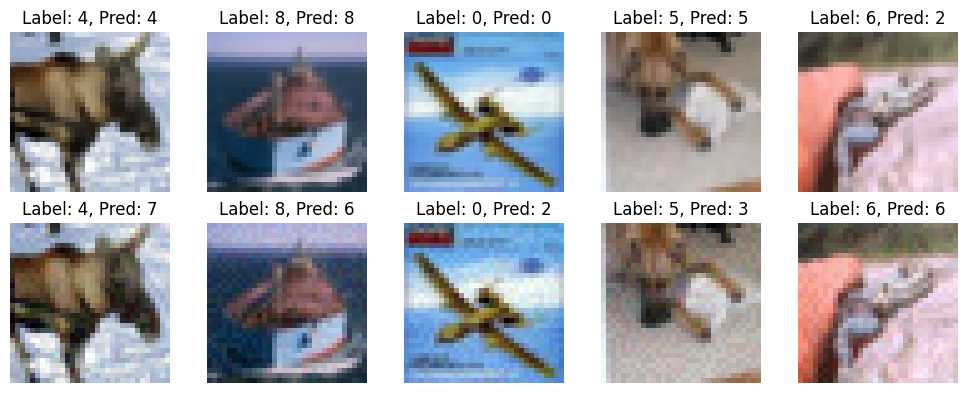

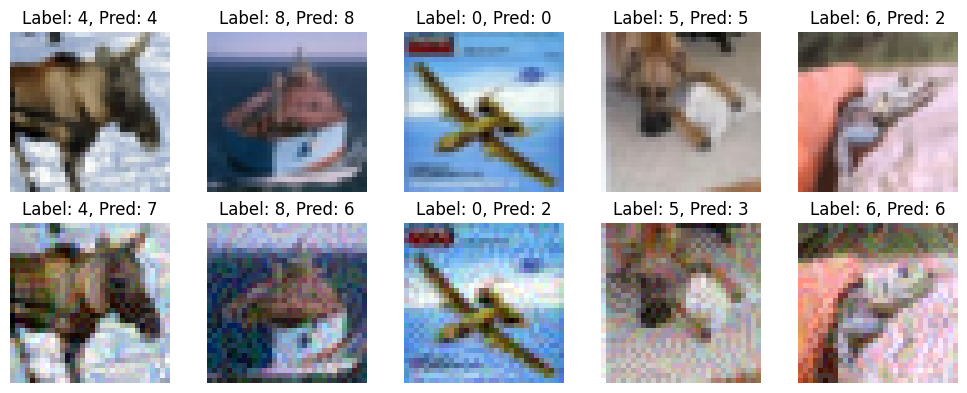

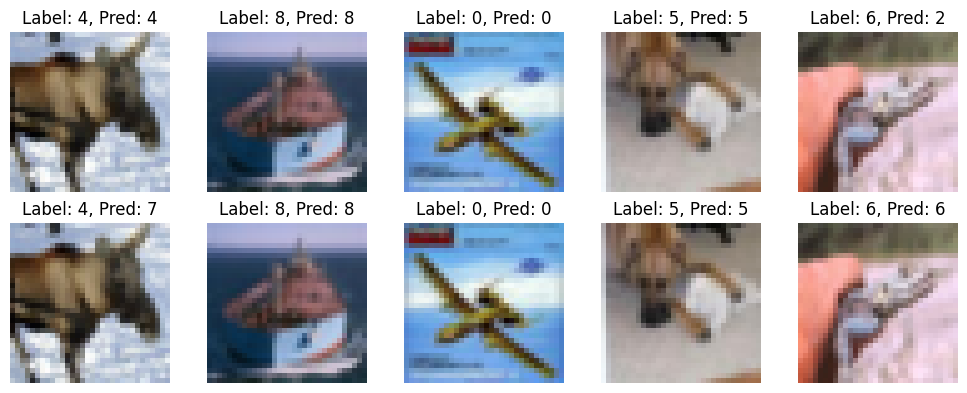

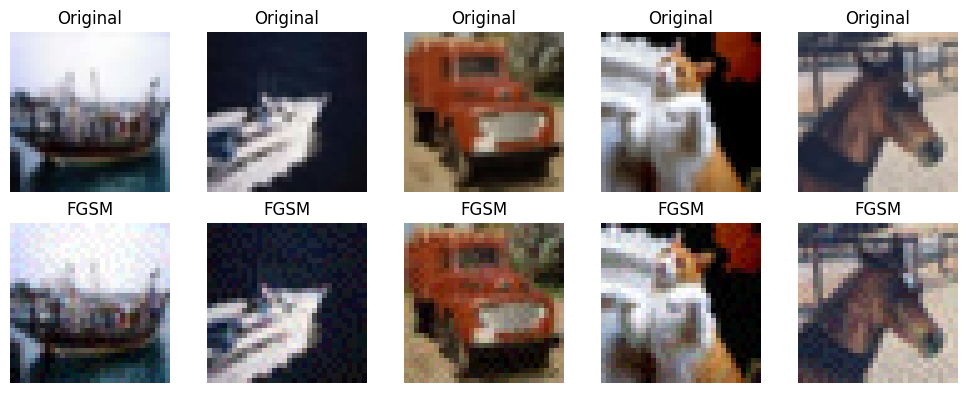

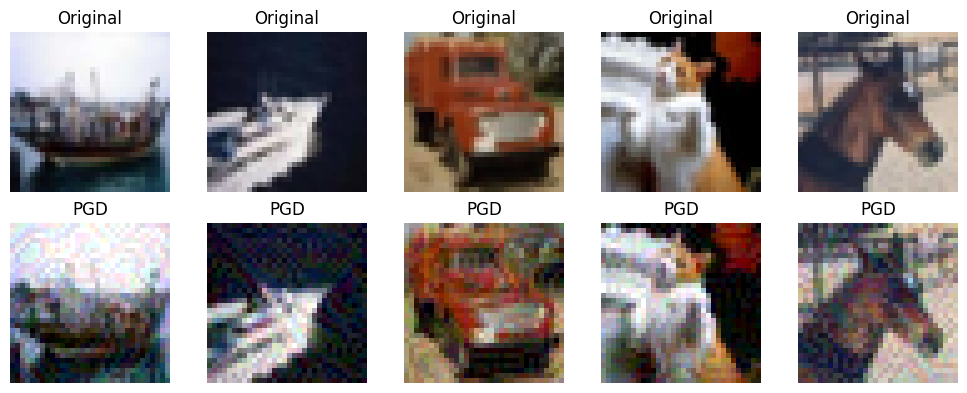

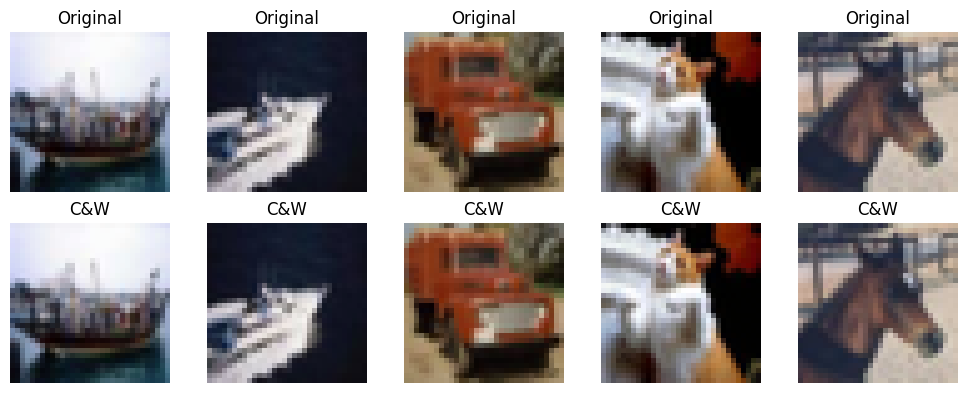

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

#####################################
#           CONFIGURATION
#####################################
model_name = "vgg16_bn"  
# Possible values from chenyaofo/pytorch-cifar-models for CIFAR-10 include:
# - "cifar10_resnet20"
# - "cifar10_vgg16_bn"
# To switch to VGG16, set model_name = "vgg16_bn"

attack_batch_size = 200   # Batch size for generating adversarial examples
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

print("Using device:", device)

#####################################
#          DATA LOADING
#####################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # Mean for CIFAR-10
        (0.2470, 0.2435, 0.2616)   # Std for CIFAR-10
    )
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
print(f"Loaded {len(images)} test images.")

classes = test_dataset.classes

#####################################
#        MODEL LOADING
#####################################
# Load the chosen model from Torch Hub
if model_name == "resnet20":
    hub_model_name = 'cifar10_resnet20'
elif model_name == "vgg16_bn":
    hub_model_name = 'cifar10_vgg16_bn'
else:
    raise ValueError("Unsupported model name. Use 'resnet20' or 'vgg16_bn' for CIFAR-10.")

print(f"Loading {hub_model_name} model from Torch Hub...")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', hub_model_name, pretrained=True)
model.to(device)
model.eval()

#####################################
#       ART CLASSIFIER WRAPPER
#####################################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

classifier_vgg16_bn = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

print("Model wrapped in ART PyTorchClassifier.")

#####################################
#        ATTACK DEFINITIONS
#####################################
# FGSM attack
attack_fgsm_vgg16 = FastGradientMethod(estimator=classifier_vgg16_bn, eps=0.1)

# PGD attack
attack_pgd_vgg16 = ProjectedGradientDescent(estimator=classifier_vgg16_bn, eps=0.3, eps_step=0.1, max_iter=40)

# C&W attack: Reduced parameters to avoid extremely long runtimes
attack_cw_vgg16 = CarliniL2Method(
    classifier=classifier_vgg16_bn,
    max_iter=200,            # Reduce from 1000
    binary_search_steps=3,   # Reduce from 9
    confidence=0
)

#####################################
#     ADVERSARIAL EXAMPLE GENERATION
#####################################
def generate_adversarial_examples(attack, x_data, batch_size=200):
    """
    Generate adversarial examples in batches to prevent excessive runtime and memory issues.
    """
    adv_examples = []
    x_data_np = x_data.cpu().numpy()
    n = len(x_data_np)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch = x_data_np[start:end]
        adv = attack.generate(x=batch)
        adv_examples.append(adv)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples

print("\nGenerating adversarial examples using FGSM...")
x_test_adv_fgsm_vgg16 = attack_fgsm_vgg16.generate(x=images.cpu().numpy())

print("Generating adversarial examples using PGD...")
x_test_adv_pgd_vgg16 = attack_pgd_vgg16.generate(x=images.cpu().numpy())

print("Generating adversarial examples using Carlini & Wagner (L2)...")
x_test_adv_cw_vgg16 = generate_adversarial_examples(attack_cw_vgg16, images, batch_size=attack_batch_size)

print("Adversarial examples generated.")

#####################################
#        EVALUATION FUNCTIONS
#####################################
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    accuracy = np.mean(preds_labels == y)
    return accuracy

#####################################
#        EVALUATE MODEL
#####################################
y_true = labels.cpu().numpy()

print("\nEvaluating model performance:")
acc_clean_vgg16 = evaluate_accuracy(classifier_vgg16_bn, images.cpu().numpy(), y_true)
print(f"Accuracy on clean examples: {acc_clean_vgg16 * 100:.2f}%")

acc_fgsm_vgg16 = evaluate_accuracy(classifier_vgg16_bn, x_test_adv_fgsm_vgg16, y_true)
print(f"Accuracy on FGSM adversarial examples: {acc_fgsm_vgg16 * 100:.2f}%")

acc_pgd_vgg16 = evaluate_accuracy(classifier_vgg16_bn, x_test_adv_pgd_vgg16, y_true)
print(f"Accuracy on PGD adversarial examples: {acc_pgd_vgg16 * 100:.2f}%")

acc_cw_vgg16 = evaluate_accuracy(classifier_vgg16_bn, x_test_adv_cw_vgg16, y_true)
print(f"Accuracy on C&W adversarial examples: {acc_cw_vgg16 * 100:.2f}%")


# Save them to .npy files
np.save("attack_fgsm_vgg16.npy", attack_fgsm_vgg16)
np.save("attack_pgd_vgg16.npy", attack_pgd_vgg16)
np.save("attack_cw_vgg16.npy", attack_cw_vgg16)
np.save("x_test_adv_fgsm_vgg16.npy", x_test_adv_fgsm_vgg16)
np.save("x_test_adv_pgd_vgg16.npy", x_test_adv_pgd_vgg16)
np.save("x_test_adv_cw_vgg16.npy", x_test_adv_cw_vgg16)


#####################################
#        SUMMARY
#####################################
print("\n=== SUMMARY OF RESULTS ===")
print(f"Model: {hub_model_name}")
print(f"Clean Accuracy: {acc_clean_vgg16 * 100:.2f}%")
print(f"FGSM Attack Accuracy: {acc_fgsm_vgg16 * 100:.2f}%")
print(f"PGD Attack Accuracy: {acc_pgd_vgg16 * 100:.2f}%")
print(f"C&W Attack Accuracy: {acc_cw_vgg16 * 100:.2f}%")


#####################################
#        OPTIONAL VISUALIZATION
#####################################
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img * std.reshape(3,1,1) + mean.reshape(3,1,1)
    return np.clip(img, 0, 1)

def plot_adversarial_examples(original, adv, title,
                              num_examples=5,
                              labels_orig=None,
                              preds_orig=None,
                              preds_adv=None):
    """
    Plots original vs. adversarial images side by side.
    If labels and predictions are provided, each subplot's title
    will show 'Label: X, Pred: Y'.
    """
    plt.figure(figsize=(10, 4))
    for i in range(num_examples):
        # --- Original image ---
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(np.transpose(denormalize(original[i]), (1, 2, 0)))
        if labels_orig is not None and preds_orig is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_orig[i]}")
        else:
            plt.title("Original")
        plt.axis('off')

        # --- Adversarial image ---
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(np.transpose(denormalize(adv[i]), (1, 2, 0)))
        if labels_orig is not None and preds_adv is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_adv[i]}")
        else:
            plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Select a few random examples to visualize
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
y_subset = y_true[indices]

# Predict on the original subset
preds_original = classifier_vgg16_bn.predict(x_original)
preds_original_labels = np.argmax(preds_original, axis=1)

# 1) FGSM
x_fgsm_vgg16 = x_test_adv_fgsm_vgg16[indices]
preds_fgsm = classifier_vgg16_bn.predict(x_fgsm_vgg16)
preds_fgsm_labels = np.argmax(preds_fgsm, axis=1)
plot_adversarial_examples(
    x_original,
    x_fgsm_vgg16,
    "FGSM",
    num_examples=num_show,
    labels_orig=y_subset,
    preds_orig=preds_original_labels,
    preds_adv=preds_fgsm_labels
)

# 2) PGD
x_pgd_vgg16 = x_test_adv_pgd_vgg16[indices]
preds_pgd = classifier_vgg16_bn.predict(x_pgd_vgg16)
preds_pgd_labels = np.argmax(preds_pgd, axis=1)
plot_adversarial_examples(
    x_original,
    x_pgd_vgg16,
    "PGD",
    num_examples=num_show,
    labels_orig=y_subset,
    preds_orig=preds_original_labels,
    preds_adv=preds_pgd_labels
)

# 3) C&W
x_cw_vgg16 = x_test_adv_cw_vgg16[indices]
preds_cw = classifier_vgg16_bn.predict(x_cw_vgg16)
preds_cw_labels = np.argmax(preds_cw, axis=1)
plot_adversarial_examples(
    x_original,
    x_cw_vgg16,
    "C&W",
    num_examples=num_show,
    labels_orig=y_subset,
    preds_orig=preds_original_labels,
    preds_adv=preds_cw_labels
)


# Visualize a few examples (optional)
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
x_fgsm_vgg16 = x_test_adv_fgsm_vgg16[indices]
x_pgd_vgg16 = x_test_adv_pgd_vgg16[indices]
x_cw_vgg16 = x_test_adv_cw_vgg16[indices]

plot_adversarial_examples(x_original, x_fgsm_vgg16, "FGSM")
plot_adversarial_examples(x_original, x_pgd_vgg16, "PGD")
plot_adversarial_examples(x_original, x_cw_vgg16, "C&W")




his code mirrors the ResNet20 version but swaps in a VGG16 model (with batch normalization) trained on CIFAR-10. It again wraps the model in an ART PyTorchClassifier, generates FGSM, PGD, and C&W attacks, and evaluates accuracy on both clean and adversarial images. Compared to ResNet20, VGG16 has higher clean accuracy (92.8%) and better FGSM resilience (45%), but PGD still drastically reduces accuracy (4.1%). The script also shows side-by-side plots of original vs. adversarial examples for a visual comparison.

Attack: FGSM (eps=0.1), Accuracy: 44.10%
Attack: PGD (eps=0.3), Accuracy: 22.50%
Attack: C&W, Accuracy: 56.20%


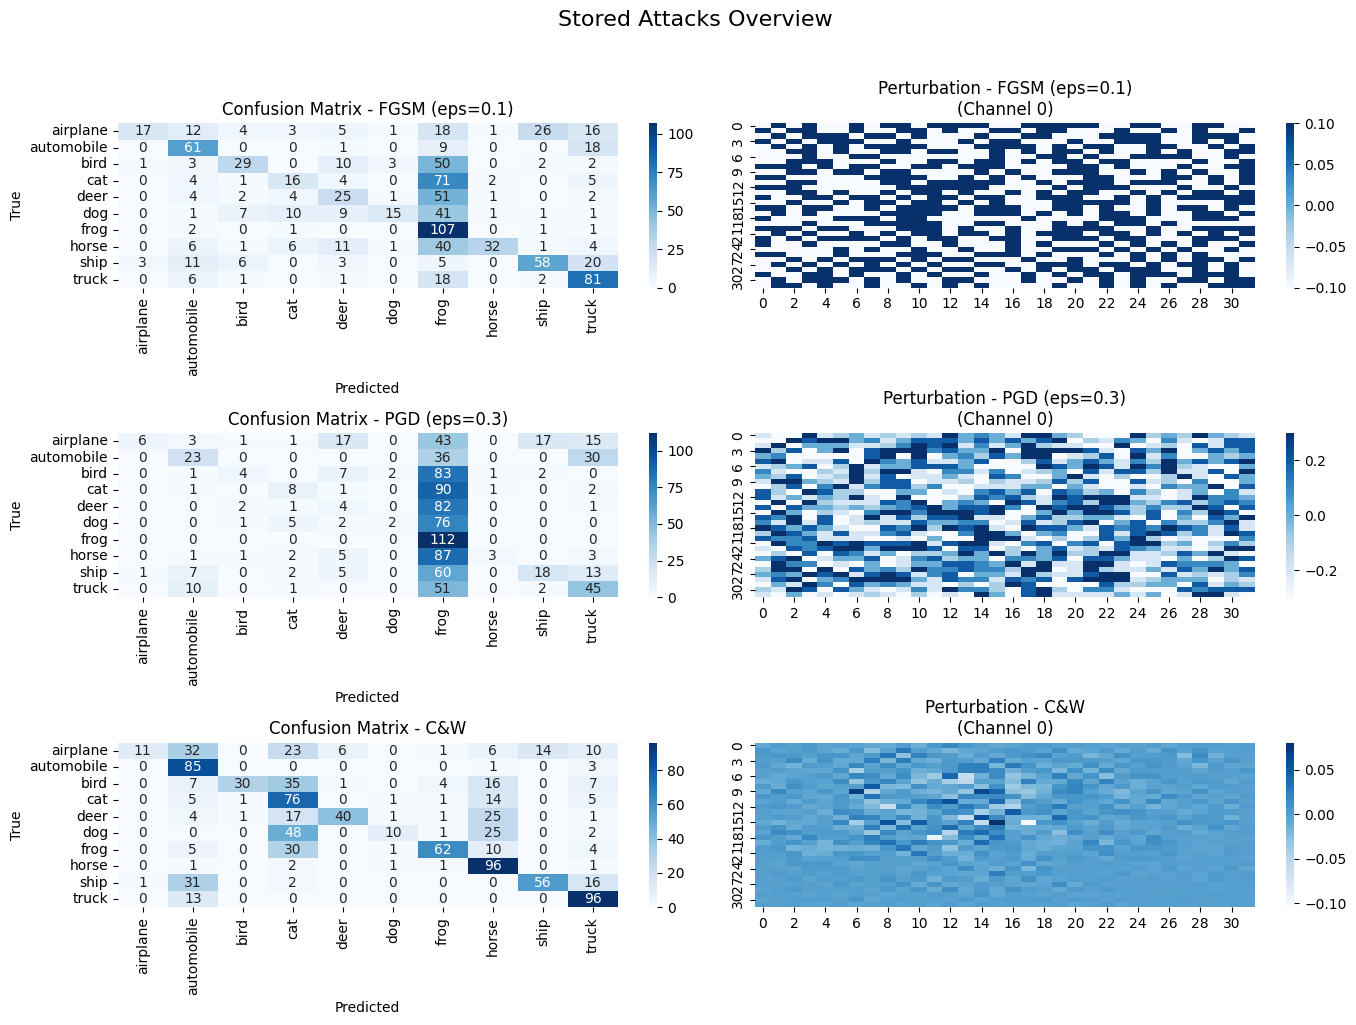

FGSM (eps=0.0): 57.40%
FGSM (eps=0.05): 53.90%
FGSM (eps=0.1): 32.10%
FGSM (eps=0.2): 15.20%
FGSM (eps=0.3): 11.90%


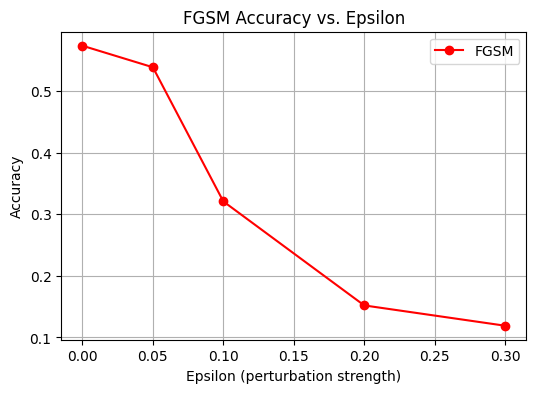

In [61]:
#################################################################
#  Example Integrated Snippet: Stored Attacks & Multi-eps FGSM
#################################################################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from art.attacks.evasion import FastGradientMethod

# 1) Stored attack data
#    (Already generated in your notebook)
attacks_data = {
    "FGSM (eps=0.1)": x_test_adv_fgsm_vgg16,
    "PGD (eps=0.3)":  x_test_adv_pgd_vgg16,
    "C&W":            x_test_adv_cw_vgg16
}



# Utility to compute accuracy and predicted labels via ART
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    return np.mean(preds_labels == y), preds_labels

# -------------------------------------------------------
#  A) Display Confusion Matrix + Perturbation Heatmap
#     for Each Stored Attack in a Single Figure
# -------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.suptitle("Stored Attacks Overview", fontsize=16, y=1.02)  # Title for entire figure

for i, (attack_name, adv_data) in enumerate(attacks_data.items()):
    # Evaluate accuracy
    acc, pred_labels = evaluate_accuracy(classifier_vgg16_bn, adv_data, y_true)
    print(f"Attack: {attack_name}, Accuracy: {acc*100:.2f}%")
    
    # (1) Confusion Matrix Subplot
    cm = confusion_matrix(y_true, pred_labels)
    sns.heatmap(
        cm, ax=axes[i, 0], cmap="Blues", annot=True, fmt="d",
        xticklabels=classes, yticklabels=classes
    )
    axes[i, 0].set_title(f"Confusion Matrix - {attack_name}")
    axes[i, 0].set_xlabel("Predicted")
    axes[i, 0].set_ylabel("True")
    
    # (2) Single-image Perturbation Heatmap Subplot
    #     We'll pick index=0 for demonstration
    original_img = images[0].cpu().numpy()
    adv_img = adv_data[0]
    # Look at channel 0 for a 2D difference
    perturbation = adv_img[0] - original_img[0]
    
    sns.heatmap(
        perturbation, ax=axes[i, 1], cmap="Blues", annot=False
    )
    axes[i, 1].set_title(f"Perturbation - {attack_name}\n(Channel 0)")

plt.tight_layout()
plt.show()

# -------------------------------------------------------
#  B) Vary FGSM eps for Additional Analysis
#     Plot Accuracy vs. Epsilon
# -------------------------------------------------------
epsilon_values = [0.0, 0.05, 0.1, 0.2, 0.3]
fgsm_accuracies = []

for eps in epsilon_values:
    fgsm_attack = FastGradientMethod(estimator=classifier_vgg16_bn, eps=eps)
    x_adv = fgsm_attack.generate(x=images.cpu().numpy())
    adv_acc, _ = evaluate_accuracy(classifier_vgg16_bn, x_adv, y_true)
    fgsm_accuracies.append(adv_acc)
    print(f"FGSM (eps={eps}): {adv_acc*100:.2f}%")

plt.figure(figsize=(6, 4))
plt.plot(epsilon_values, fgsm_accuracies, marker='o', color='r', label='FGSM')
plt.title("FGSM Accuracy vs. Epsilon")
plt.xlabel("Epsilon (perturbation strength)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


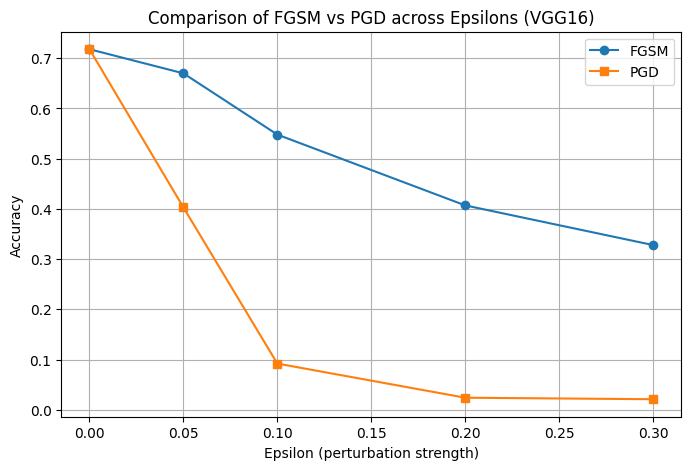

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent


def evaluate_accuracy(classifier, x, y):
    """
    Utility to compute accuracy using an ART classifier.
    Returns a float in [0,1].
    """
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    return np.mean(preds_labels == y)

# Define epsilon values to experiment with
epsilon_values = [0.0, 0.05, 0.1, 0.2, 0.3]

# We'll store accuracies in these lists
fgsm_accuracies = []
pgd_accuracies = []

# Loop through each epsilon
for eps in epsilon_values:
    # ========== FGSM Attack ==========
    fgsm_attack = FastGradientMethod(
        estimator=classifier_resnet,
        eps=eps
    )
    # Generate adversarial examples
    x_adv_fgsm = fgsm_attack.generate(x=images.cpu().numpy())
    # Evaluate accuracy
    acc_fgsm = evaluate_accuracy(classifier_vgg16_bn, x_adv_fgsm, y_true)
    fgsm_accuracies.append(acc_fgsm)
    
    # ========== PGD Attack ==========
    # Note: You can keep eps_step=0.1 or something proportionate to eps
    pgd_attack = ProjectedGradientDescent(
        estimator=classifier_vgg16_bn,
        eps=eps,
        eps_step=0.1,     # Adjust as needed
        max_iter=40       # Adjust as needed
    )
    # Generate adversarial examples
    x_adv_pgd = pgd_attack.generate(x=images.cpu().numpy())
    # Evaluate accuracy
    acc_pgd = evaluate_accuracy(classifier_vgg16_bn, x_adv_pgd, y_true)
    pgd_accuracies.append(acc_pgd)

# ===== PLOTTING =====
plt.figure(figsize=(8,5))
plt.plot(epsilon_values, fgsm_accuracies, marker='o', label='FGSM')
plt.plot(epsilon_values, pgd_accuracies, marker='s', label='PGD')
plt.title('Comparison of FGSM vs PGD across Epsilons (VGG16)')
plt.xlabel('Epsilon (perturbation strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


This is accuatly VGG and not Resnet, but because of training time.
We left the title like this!


Classification Report - FGSM Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.26      0.50      0.34        14
  automobile       0.92      0.53      0.68        43
        bird       0.67      0.72      0.69       117
         cat       0.89      0.65      0.75       171
        deer       0.81      0.53      0.64        91
        frog       0.61      0.94      0.74       139
       horse       0.97      0.76      0.86       102
        ship       0.76      0.97      0.85       157
       truck       0.86      0.75      0.80       166

    accuracy                           0.76      1000
   macro avg       0.75      0.71      0.71      1000
weighted avg       0.79      0.76      0.76      1000


Classification Report - PGD Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.14      0.36      0.20        14
  automobile       0.44      0.16      0.24        43
        bird       0.44      

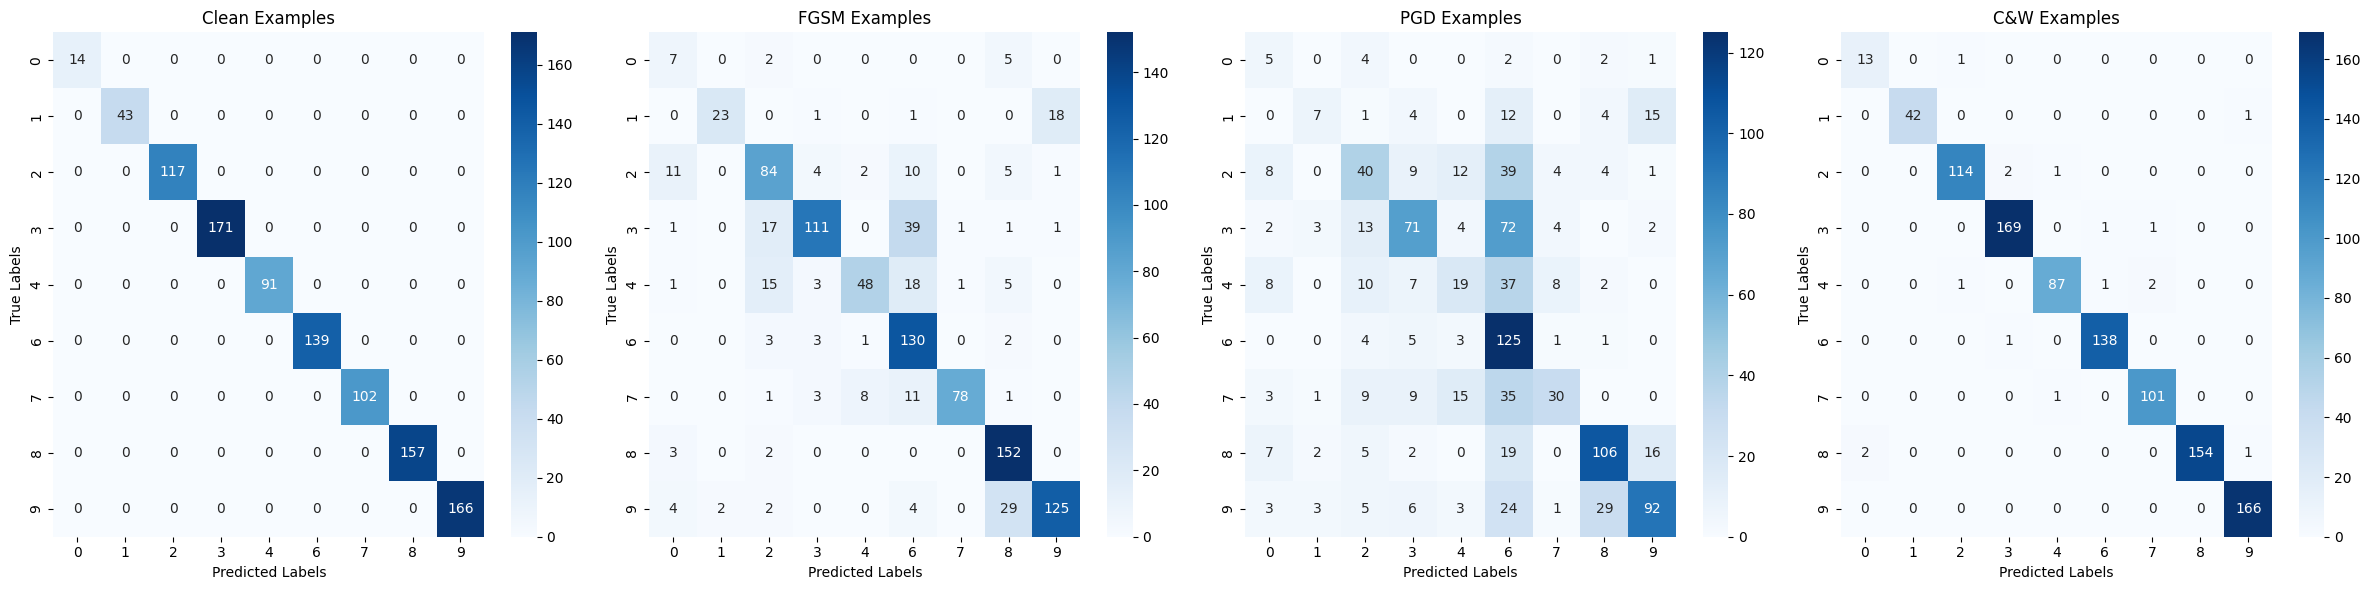

In [22]:
# Dynamically determine unique labels from y_true or predictions
unique_classes_vgg = np.unique(y_true)

# Generate clean predictions
y_pred_clean_vgg = np.argmax(classifier_vgg16_bn.predict(images.cpu().numpy()), axis=1)

# Generate confusion matrix for clean examples
cm_clean_vgg = confusion_matrix(y_true, y_pred_clean_vgg, labels=unique_classes_vgg)

# Evaluate adversarial examples and generate confusion matrices
confusion_matrices_vgg = [cm_clean_vgg]
titles_vgg = ["Clean Examples"]

for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_vgg16),
    ("PGD", x_test_adv_pgd_vgg16),
    ("C&W", x_test_adv_cw_vgg16)
]:
    y_pred_adv_vgg = np.argmax(classifier_vgg16_bn.predict(adv_examples), axis=1)
    cm_adv_vgg = confusion_matrix(y_true, y_pred_adv_vgg, labels=unique_classes_vgg)
    confusion_matrices_vgg.append(cm_adv_vgg)
    titles_vgg.append(f"{attack_name} Examples")

    # Print classification report using unique classes
    print(f"\nClassification Report - {attack_name} Adversarial Examples:")
    print(classification_report(y_true, y_pred_adv_vgg, labels=unique_classes_vgg, target_names=[classes[i] for i in unique_classes_vgg]))

# Plot all confusion matrices side by side
plot_side_by_side_confusion_matrices(confusion_matrices_vgg, titles_vgg, unique_classes_vgg)


#Some observations about vgg16 model

In [17]:
# Use clean predictions from ResNet as pseudo-labels
y_pred_clean_resnet = np.argmax(classifier_resnet.predict(images.cpu().numpy()), axis=1)

# Treat `y_pred_clean_resnet` as the reference labels for comparison
for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_resnet20),
    ("PGD", x_test_adv_pgd_resnet20),
    ("C&W", x_test_adv_cw_resnet20),
]:
    y_pred_adv_resnet = np.argmax(classifier_resnet.predict(adv_examples), axis=1)
    
    # Compare clean predictions to adversarial predictions
    print(f"\nComparison - {attack_name} Adversarial Examples (ResNet):")
    print(f"Clean Predictions: {y_pred_clean_resnet[:10]}")
    print(f"Adversarial Predictions: {y_pred_adv_resnet[:10]}")



Comparison - FGSM Adversarial Examples (ResNet):
Clean Predictions: [3 8 8 8 6 6 1 7 3 1]
Adversarial Predictions: [4 8 9 8 6 6 1 6 6 9]

Comparison - PGD Adversarial Examples (ResNet):
Clean Predictions: [3 8 8 8 6 6 1 7 3 1]
Adversarial Predictions: [6 8 6 8 6 6 9 6 6 6]

Comparison - C&W Adversarial Examples (ResNet):
Clean Predictions: [3 8 8 8 6 6 1 7 3 1]
Adversarial Predictions: [3 8 8 8 6 7 1 7 3 1]



Classification Report - FGSM Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.29      0.50      0.36        12
  automobile       0.86      0.51      0.64       185
        bird       0.18      0.28      0.22        32
         cat       0.57      0.10      0.17       230
        deer       0.23      0.33      0.27        48
         dog       0.10      0.14      0.11        14
        frog       0.18      0.99      0.31        76
       horse       0.92      0.18      0.30       190
        ship       0.58      0.78      0.67        68
       truck       0.60      0.62      0.61       145

    accuracy                           0.40      1000
   macro avg       0.45      0.44      0.37      1000
weighted avg       0.63      0.40      0.40      1000


Classification Report - PGD Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.14      0.08      0.11        12
  automobile       0.80      

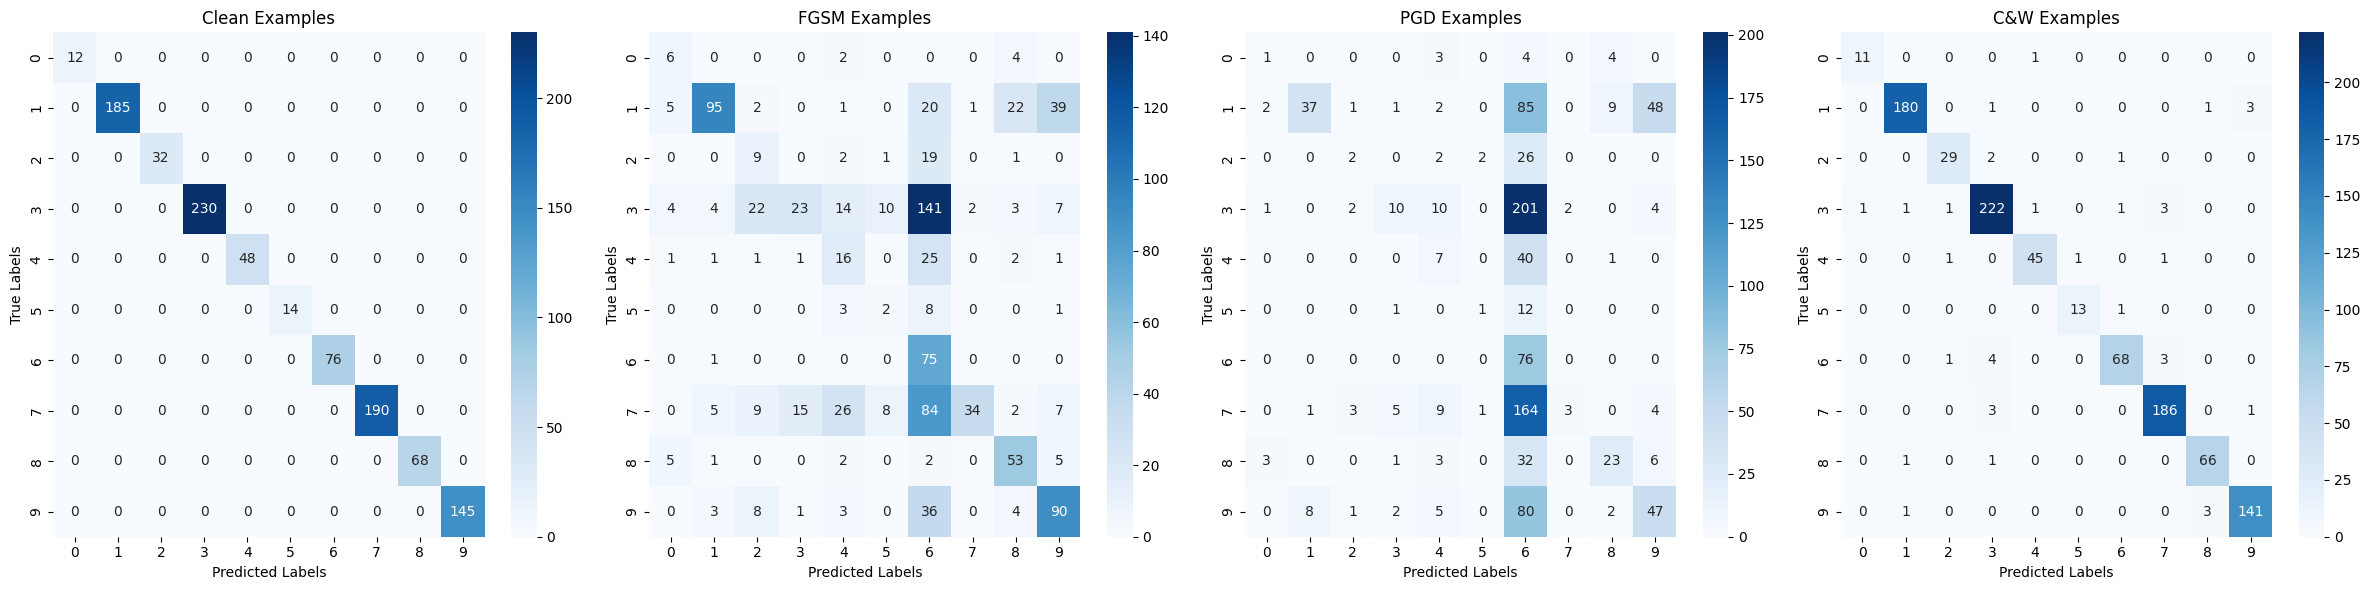

In [19]:
#####################################
#         PERFORMANCE ANALYSIS
#####################################
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Ensure labels are dynamically aligned with the dataset
unique_labels = np.unique(y_pred_clean_resnet)  # Using predictions from clean examples as pseudo-labels

# Generate clean predictions to use as pseudo ground-truth labels
y_pred_clean_resnet = np.argmax(classifier_resnet.predict(images.cpu().numpy()), axis=1)

# Generate confusion matrix for clean examples
cm_clean = confusion_matrix(y_pred_clean_resnet, y_pred_clean_resnet, labels=unique_labels)

# Evaluate adversarial examples and generate confusion matrices
confusion_matrices = [cm_clean]
titles = ["Clean Examples"]

for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_resnet20),
    ("PGD", x_test_adv_pgd_resnet20),
    ("C&W", x_test_adv_cw_resnet20)
]:
    y_pred_adv_resnet = np.argmax(classifier_resnet.predict(adv_examples), axis=1)
    cm_adv = confusion_matrix(y_pred_clean_resnet, y_pred_adv_resnet, labels=unique_labels)
    confusion_matrices.append(cm_adv)
    titles.append(f"{attack_name} Examples")

    # Print classification report
    print(f"\nClassification Report - {attack_name} Adversarial Examples:")
    print(classification_report(y_pred_clean_resnet, y_pred_adv_resnet, target_names=classes))

# Plot all confusion matrices side by side
plot_side_by_side_confusion_matrices(confusion_matrices, titles, unique_labels)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent


def evaluate_accuracy(classifier, x, y):
    """
    Utility to compute accuracy using an ART classifier.
    Returns a float in [0,1].
    """
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    return np.mean(preds_labels == y)

# Define epsilon values to experiment with
epsilon_values = [0.0, 0.05, 0.1, 0.2, 0.3]

# We'll store accuracies in these lists
fgsm_accuracies = []
pgd_accuracies = []

# Loop through each epsilon
for eps in epsilon_values:
    # ========== FGSM Attack ==========
    fgsm_attack = FastGradientMethod(
        estimator=classifier_resnet,
        eps=eps
    )
    # Generate adversarial examples
    x_adv_fgsm = fgsm_attack.generate(x=images.cpu().numpy())
    # Evaluate accuracy
    acc_fgsm = evaluate_accuracy(classifier_resnet, x_adv_fgsm, y_pred_clean_resnet)
    fgsm_accuracies.append(acc_fgsm)
    
    # ========== PGD Attack ==========
    # Note: You can keep eps_step=0.1 or something proportionate to eps
    pgd_attack = ProjectedGradientDescent(
        estimator=classifier_resnet,
        eps=eps,
        eps_step=0.1,     # Adjust as needed
        max_iter=40       # Adjust as needed
    )
    # Generate adversarial examples
    x_adv_pgd = pgd_attack.generate(x=images.cpu().numpy())
    # Evaluate accuracy
    acc_pgd = evaluate_accuracy(classifier_resnet, x_adv_pgd, y_pred_clean_resnet)
    pgd_accuracies.append(acc_pgd)

# ===== PLOTTING =====
plt.figure(figsize=(8,5))
plt.plot(epsilon_values, fgsm_accuracies, marker='o', label='FGSM')
plt.plot(epsilon_values, pgd_accuracies, marker='s', label='PGD')
plt.title('Comparison of FGSM vs PGD across Epsilons (ResNet20)')
plt.xlabel('Epsilon (perturbation strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


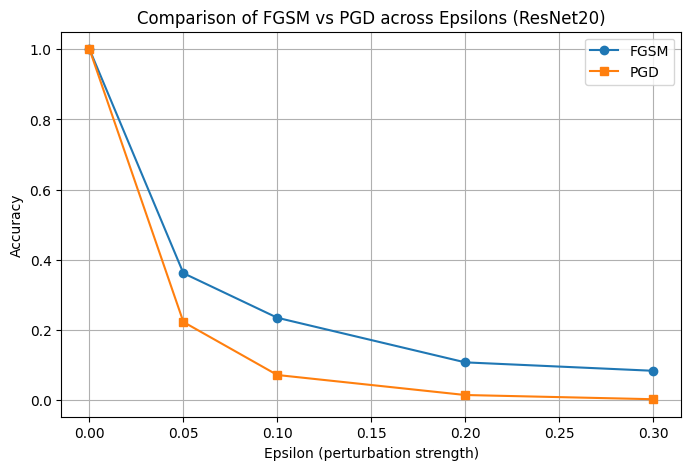

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent



def evaluate_accuracy(classifier, x, y):
    """
    Utility to compute accuracy using an ART classifier.
    Returns a float in [0,1].
    """
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    return np.mean(preds_labels == y)

# Define epsilon values to experiment with
epsilon_values = [0.0, 0.05, 0.1, 0.2, 0.3]

# We'll store accuracies in these lists
fgsm_accuracies = []
pgd_accuracies = []

# Loop through each epsilon
for eps in epsilon_values:
    # ========== FGSM Attack ==========
    fgsm_attack = FastGradientMethod(
        estimator=classifier_resnet,
        eps=eps
    )
    # Generate adversarial examples
    x_adv_fgsm = fgsm_attack.generate(x=images.cpu().numpy())
    # Evaluate accuracy
    acc_fgsm = evaluate_accuracy(classifier_resnet, x_adv_fgsm, y_pred_clean_resnet)
    fgsm_accuracies.append(acc_fgsm)
    
    # ========== PGD Attack ==========
    # Note: You can keep eps_step=0.1 or something proportionate to eps
    pgd_attack = ProjectedGradientDescent(
        estimator=classifier_resnet,
        eps=eps,
        eps_step=0.1,     # Adjust as needed
        max_iter=40       # Adjust as needed
    )
    # Generate adversarial examples
    x_adv_pgd = pgd_attack.generate(x=images.cpu().numpy())
    # Evaluate accuracy
    acc_pgd = evaluate_accuracy(classifier_resnet, x_adv_pgd, y_pred_clean_resnet)
    pgd_accuracies.append(acc_pgd)

# ===== PLOTTING =====
plt.figure(figsize=(8,5))
plt.plot(epsilon_values, fgsm_accuracies, marker='o', label='FGSM')
plt.plot(epsilon_values, pgd_accuracies, marker='s', label='PGD')
plt.title('Comparison of FGSM vs PGD across Epsilons (ResNet20)')
plt.xlabel('Epsilon (perturbation strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_predictions(image, true_label, predictions, top_k=5, adv_image=None, perturbation=None, label_names=None, norm_mean=None, norm_std=None):
    """
    Visualizes predictions for a given image, optionally including adversarial examples and noise.
    
    Parameters:
    - image (torch.Tensor or numpy.ndarray): Original input image.
    - true_label (int): Ground truth label for the image.
    - predictions (torch.Tensor or numpy.ndarray): Model predictions (logits or probabilities).
    - top_k (int): Number of top predictions to display.
    - adv_image (torch.Tensor or numpy.ndarray, optional): Adversarial image, if available.
    - perturbation (torch.Tensor or numpy.ndarray, optional): Perturbation or noise added to the image.
    - label_names (list of str): List of class label names corresponding to indices.
    - norm_mean (list of float): Mean values for normalization (per channel).
    - norm_std (list of float): Standard deviation values for normalization (per channel).
    
    Returns:
    None. Displays the visualization directly.
    """
    if isinstance(image, torch.Tensor):
        # Convert Torch tensor to numpy array and denormalize
        image = image.cpu().permute(1, 2, 0).numpy()
        image = (image * np.array(norm_std)[None, None, :]) + np.array(norm_mean)[None, None, :]
        image = np.clip(image, 0.0, 1.0)
        true_label = int(true_label)

    # Define subplot configuration based on whether adversarial data is provided
    if adv_image is None or perturbation is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 2]})
    else:
        fig, axes = plt.subplots(1, 5, figsize=(15, 3), gridspec_kw={'width_ratios': [1, 1, 1, 0.2, 2]})

    # Plot the original image with its true label
    axes[0].imshow(image)
    axes[0].set_title(f"Original: {label_names[true_label]}")
    axes[0].axis('off')

    if adv_image is not None and perturbation is not None:
        # Visualize the adversarial image
        adv_image = adv_image.cpu().permute(1, 2, 0).numpy()
        adv_image = (adv_image * np.array(norm_std)[None, None, :]) + np.array(norm_mean)[None, None, :]
        adv_image = np.clip(adv_image, 0.0, 1.0)
        axes[1].imshow(adv_image)
        axes[1].set_title("Adversarial")
        axes[1].axis('off')

        # Visualize the perturbation
        perturbation = perturbation.cpu().permute(1, 2, 0).numpy()
        perturbation = (perturbation * 0.5) + 0.5  # Scale to [0, 1]
        axes[2].imshow(perturbation)
        axes[2].set_title("Perturbation")
        axes[2].axis('off')

        # Empty buffer space for alignment
        axes[3].axis('off')

    # Normalize predictions if they are logits
    if isinstance(predictions, torch.Tensor) and abs(predictions.sum().item() - 1.0) > 1e-4:
        predictions = torch.softmax(predictions, dim=-1)
    predictions = predictions.cpu().numpy()

    # Get the top-k predictions
    topk_values, topk_indices = torch.topk(torch.tensor(predictions), top_k)
    topk_values, topk_indices = topk_values.numpy(), topk_indices.numpy()

    # Plot the horizontal bar chart for predictions
    axes[-1].barh(
        np.arange(top_k), topk_values * 100.0, align='center',
        color=["#1f77b4" if idx != true_label else "#2ca02c" for idx in topk_indices]
    )
    axes[-1].set_yticks(np.arange(top_k))
    axes[-1].set_yticklabels([label_names[idx] for idx in topk_indices])
    axes[-1].invert_yaxis()
    axes[-1].set_xlabel("Confidence (%)")
    axes[-1].set_title("Top Predictions")

    # Finalize and show the plot
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7830755..2.0942786].


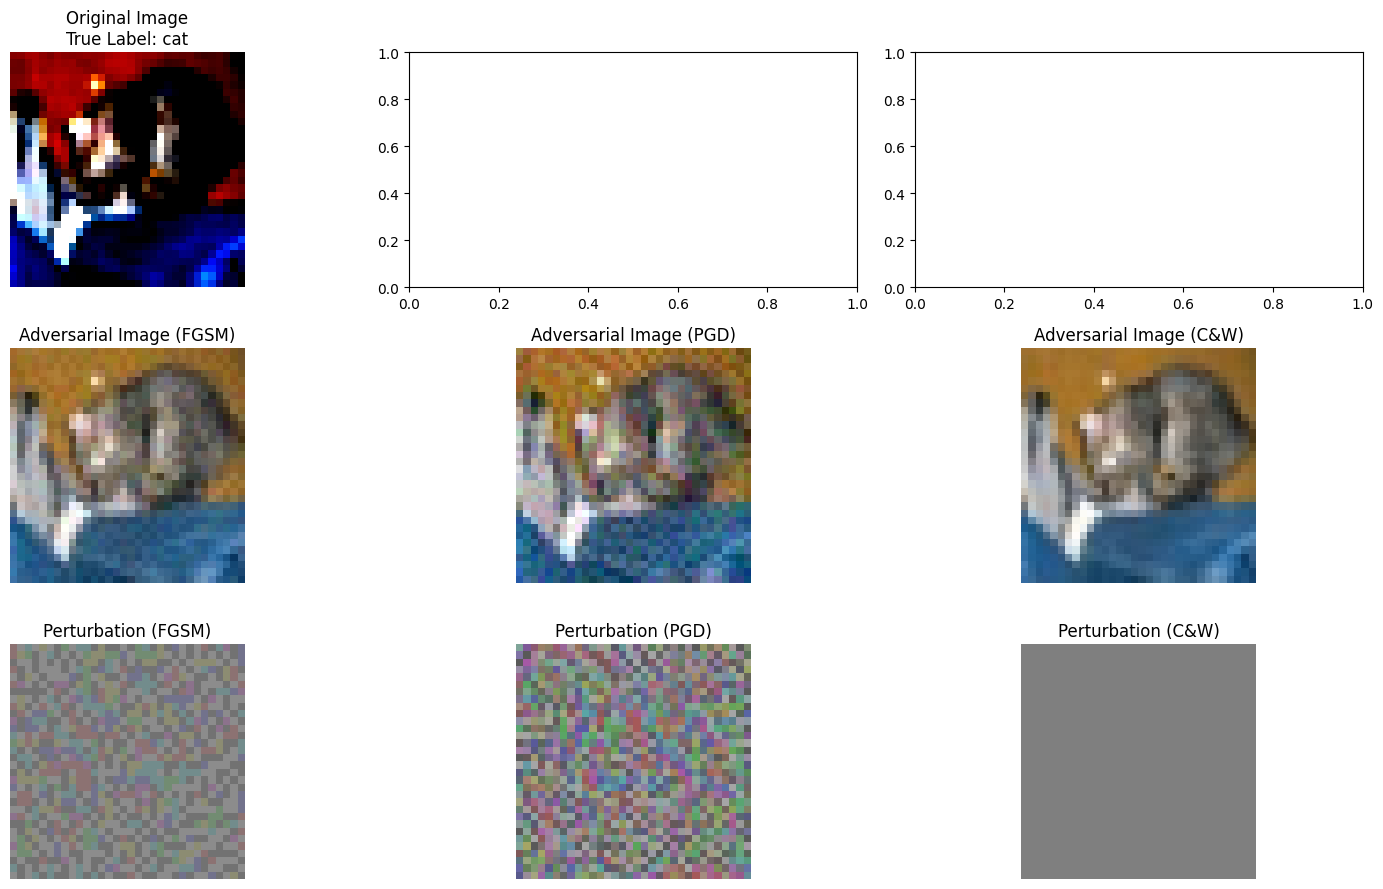

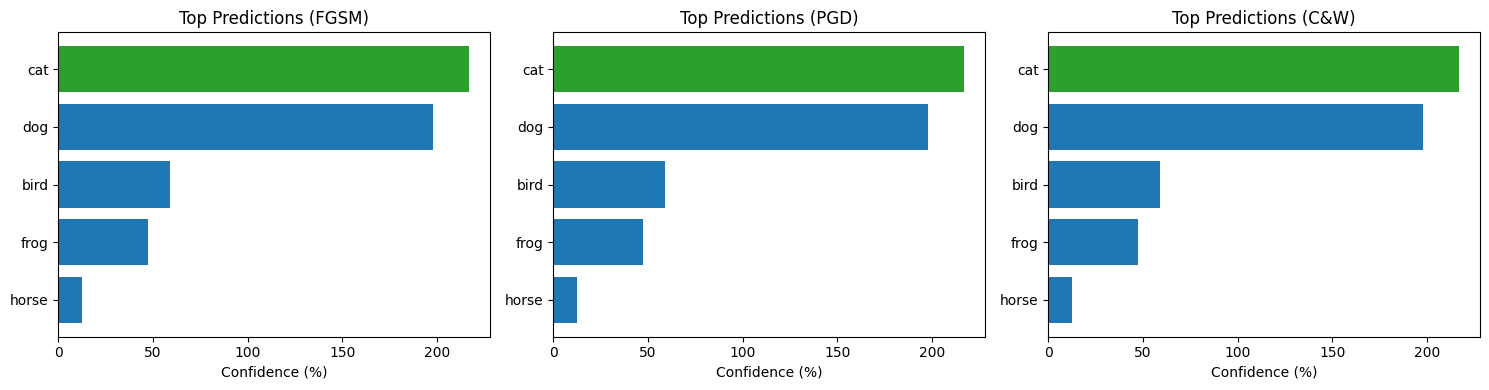

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9959002].


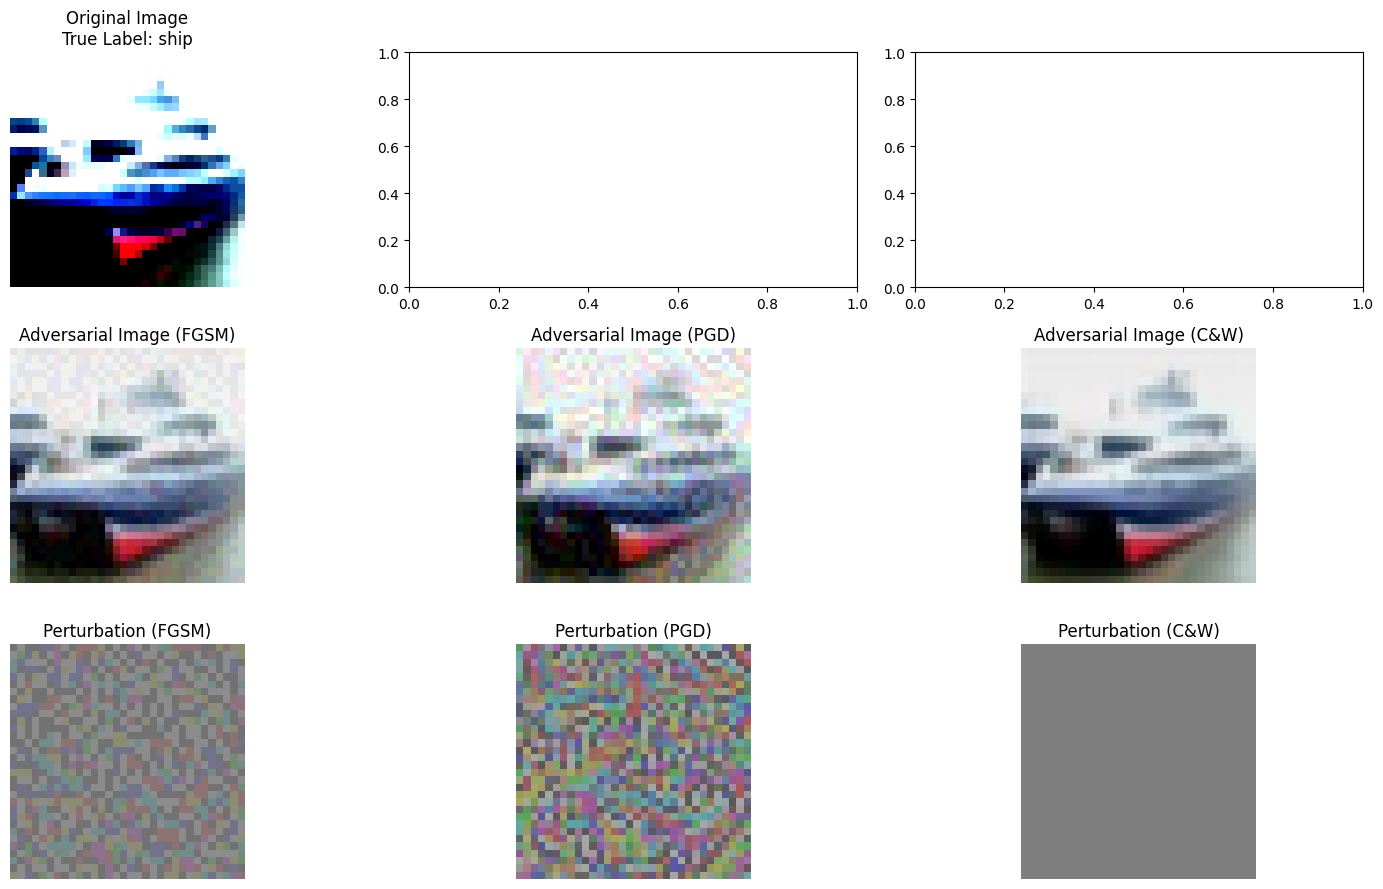

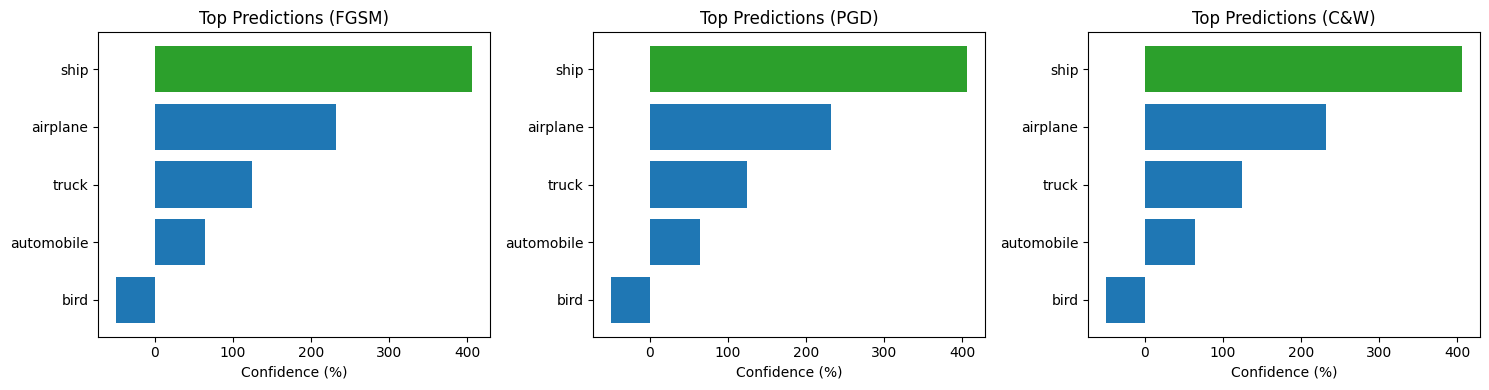

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259666..2.0708537].


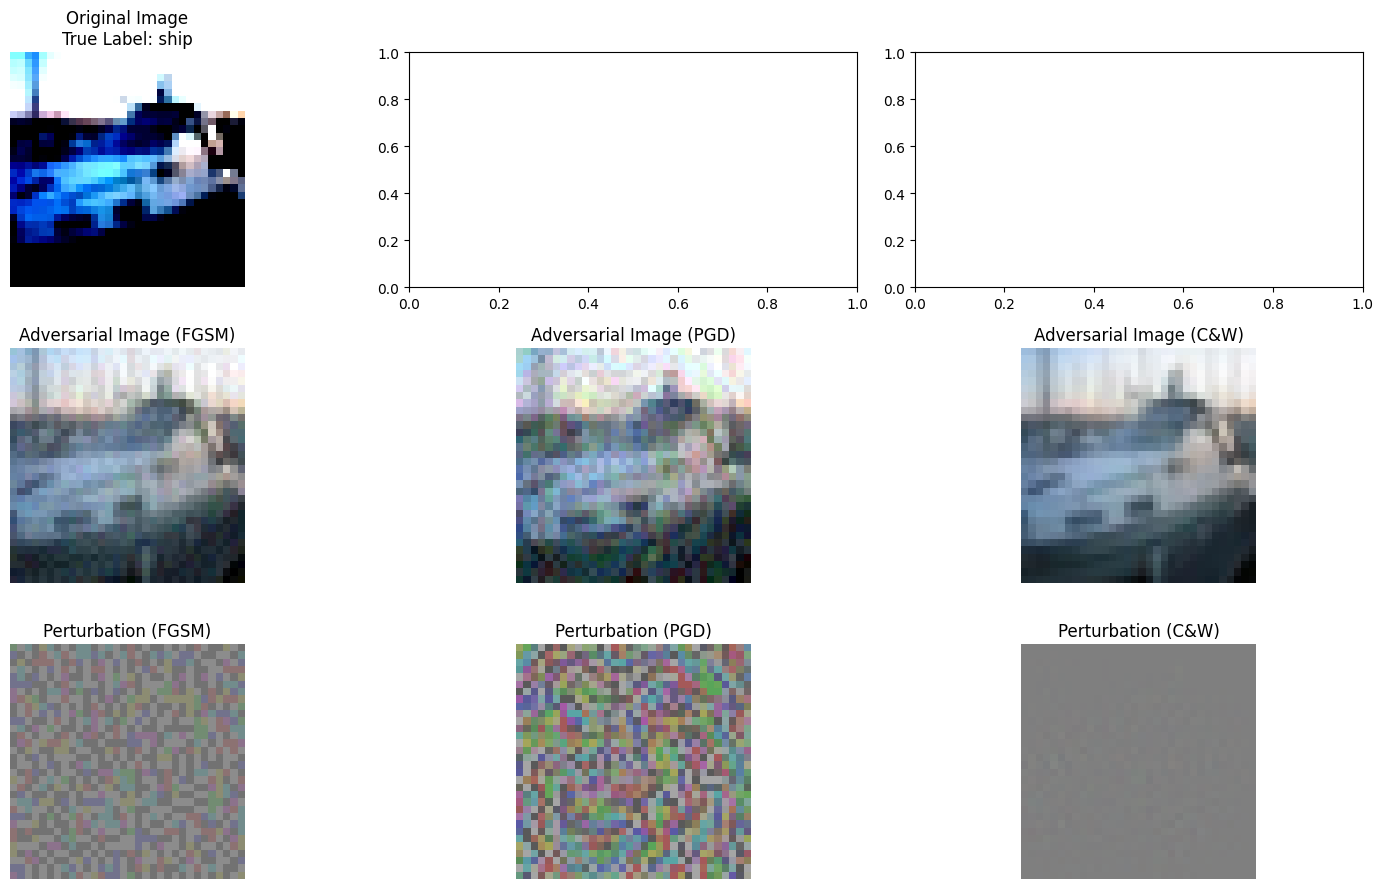

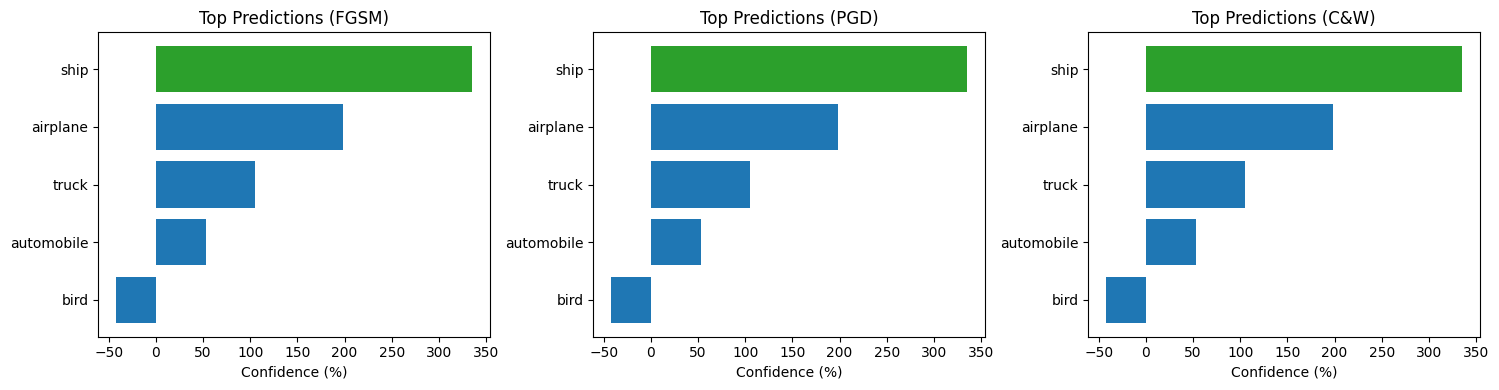

In [38]:
# Compare attacks side by side for the same sample
for idx in range(3):  # Visualize first 5 examples
    image = images[idx]
    true_label = labels[idx]

    # Dictionary to hold attack results for visualization
    attack_results = {}

    # Loop through each attack
    for attack_name, adv_examples in [
        ("FGSM", x_test_adv_fgsm_vgg16),
        ("PGD", x_test_adv_pgd_vgg16),
        ("C&W", x_test_adv_cw_vgg16)
    ]:
        # Get adversarial image and perturbation
        adv_image = adv_examples[idx]
        adv_image = torch.tensor(adv_image).to(image.device)
        perturbation = adv_image - image

        # Get model predictions for the adversarial image
        predictions = classifier_vgg16_bn.predict(image.unsqueeze(0)).squeeze()

        # Store results for the current attack
        attack_results[attack_name] = {
            "adv_image": adv_image,
            "perturbation": perturbation,
            "predictions": torch.tensor(predictions)
        }

    # Visualization: Plot results side by side
    num_attacks = len(attack_results)
    fig, axes = plt.subplots(3, num_attacks, figsize=(5 * num_attacks, 9))

    for col, (attack_name, result) in enumerate(attack_results.items()):
        # Original Image
        if col == 0:
            axes[0, col].imshow(image.cpu().permute(1, 2, 0).numpy())
            axes[0, col].set_title("Original Image\nTrue Label: " + classes[true_label])
            axes[0, col].axis("off")

        # Adversarial Image
        adv_image = result["adv_image"].cpu().permute(1, 2, 0).numpy()
        adv_image = (adv_image * np.array([0.2470, 0.2435, 0.2616])[None, None, :]) + np.array([0.4914, 0.4822, 0.4465])[None, None, :]
        adv_image = np.clip(adv_image, 0, 1)
        axes[1, col].imshow(adv_image)
        axes[1, col].set_title(f"Adversarial Image ({attack_name})")
        axes[1, col].axis("off")

        # Perturbation
        perturbation = result["perturbation"].cpu().permute(1, 2, 0).numpy()
        perturbation = (perturbation * 0.5) + 0.5  # Scale to [0, 1]
        axes[2, col].imshow(perturbation)
        axes[2, col].set_title(f"Perturbation ({attack_name})")
        axes[2, col].axis("off")

    plt.tight_layout()
    plt.show()

    # Bar Chart Comparison: Predictions for Each Attack
    fig, ax = plt.subplots(1, num_attacks, figsize=(5 * num_attacks, 4))

    for col, (attack_name, result) in enumerate(attack_results.items()):
        predictions = result["predictions"]
        topk_vals, topk_idx = torch.topk(predictions, 5)
        topk_vals, topk_idx = topk_vals.numpy(), topk_idx.numpy()

        # Bar chart for predictions
        ax[col].barh(np.arange(5), topk_vals * 100.0, align='center', color=["#1f77b4" if idx != true_label else "#2ca02c" for idx in topk_idx])
        ax[col].set_yticks(np.arange(5))
        ax[col].set_yticklabels([classes[i] for i in topk_idx])
        ax[col].invert_yaxis()
        ax[col].set_xlabel("Confidence (%)")
        ax[col].set_title(f"Top Predictions ({attack_name})")

    plt.tight_layout()
    plt.show()


**Visual Comparison:** This section shows the original image, adversarial images generated by FGSM, PGD, and C&W attacks, and their corresponding perturbations. Compare how each attack modifies the input visually.

**Prediction Comparison:** This section displays the top 3 predictions for each attack, highlighting how the model's confidence changes under adversarial conditions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7830755..2.0942786].


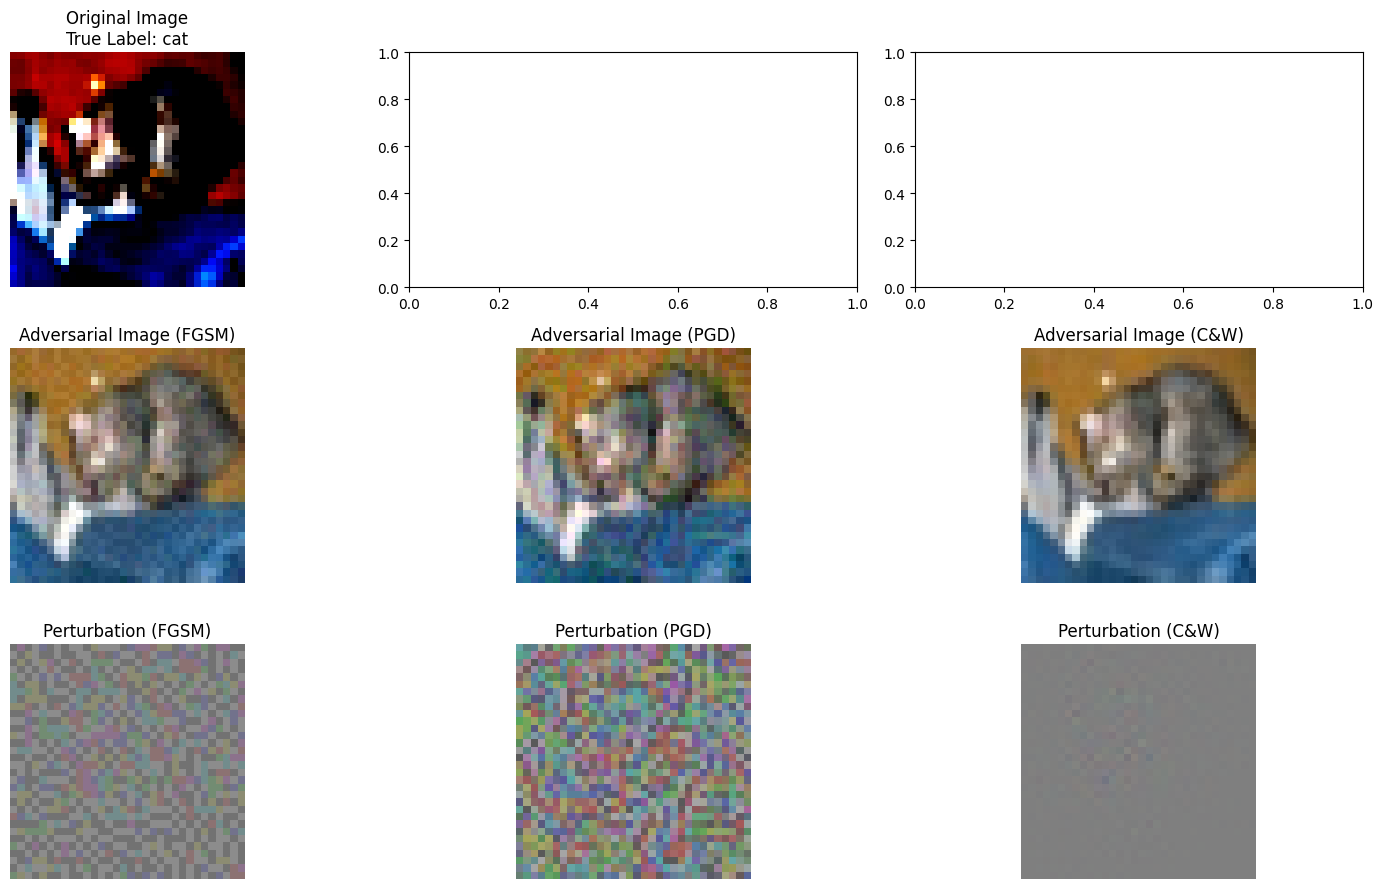

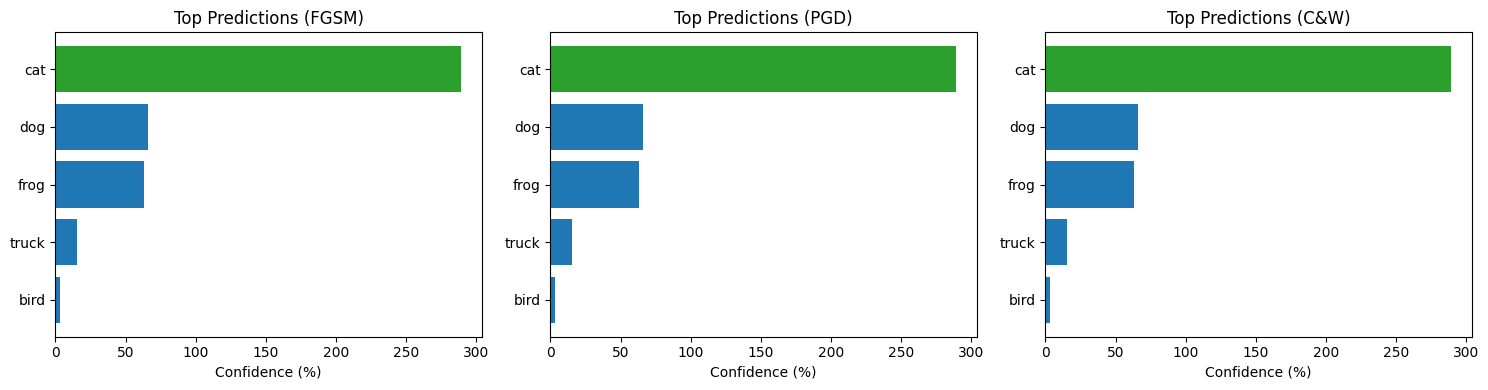

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9959002].


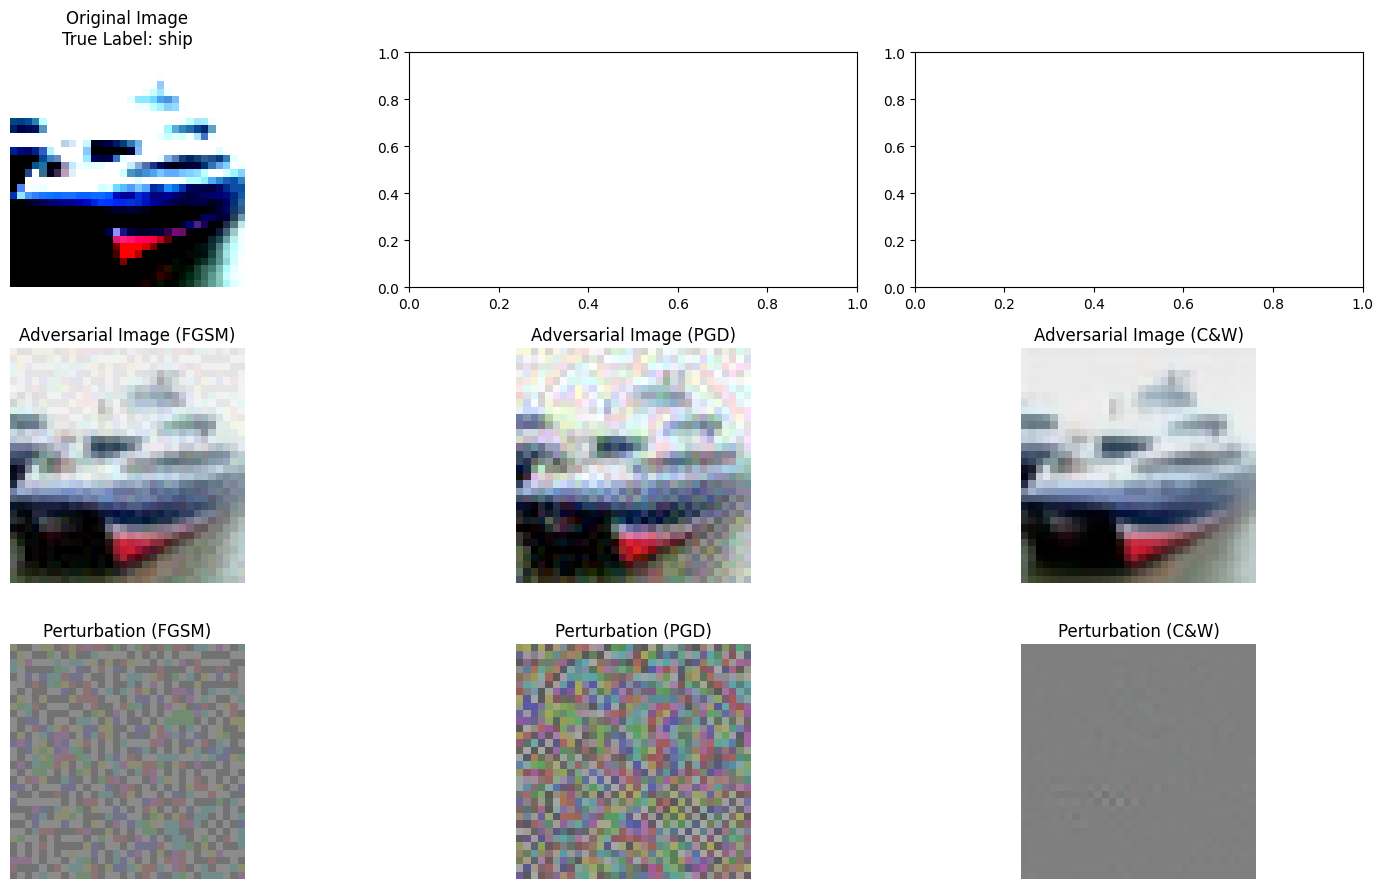

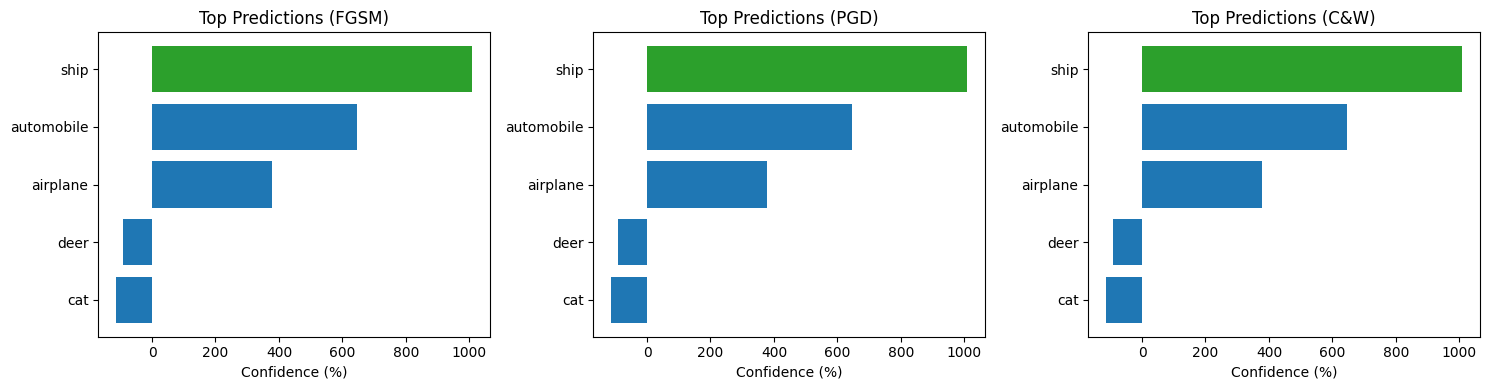

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259666..2.0708537].


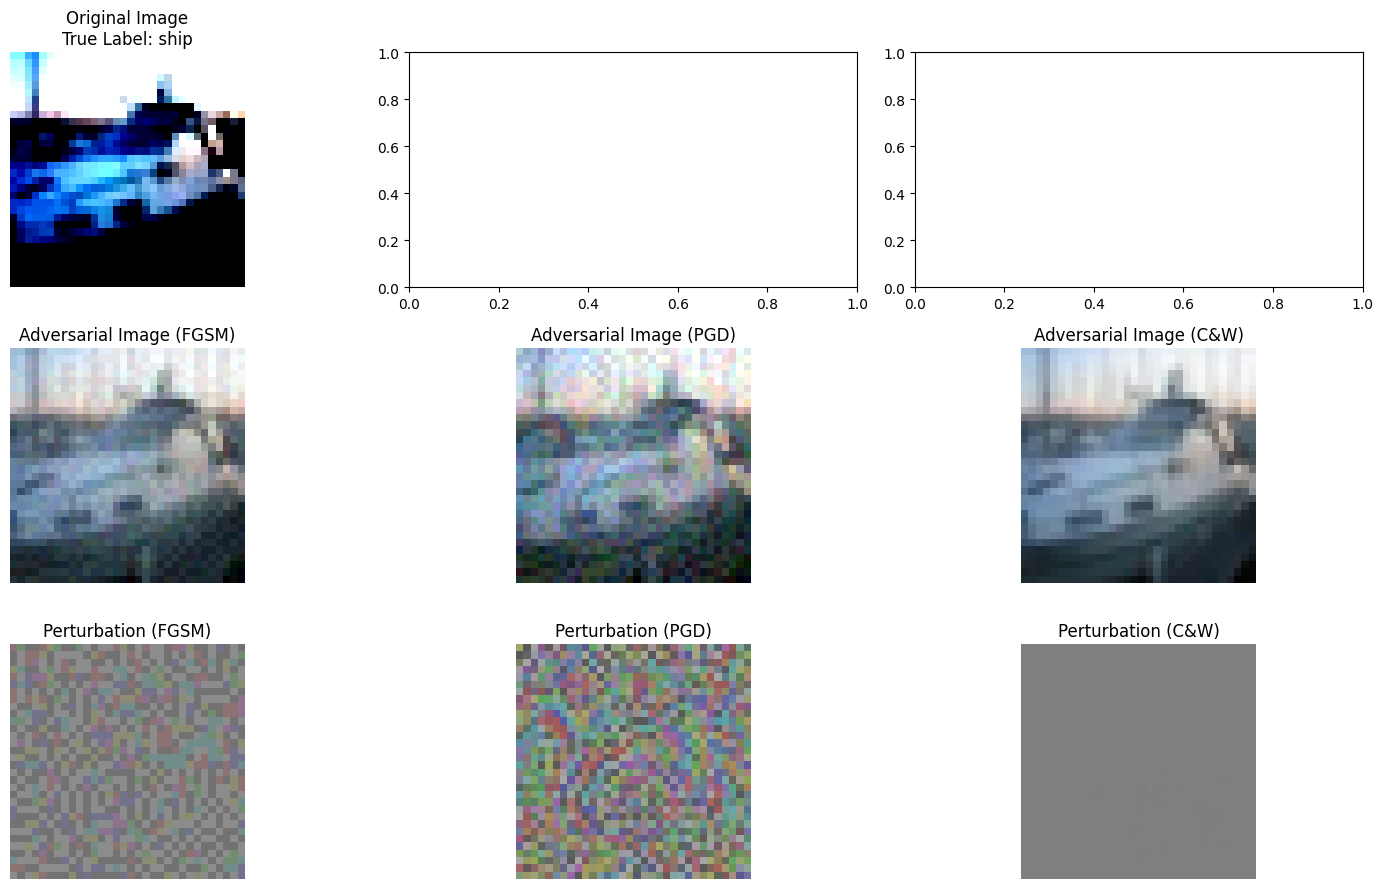

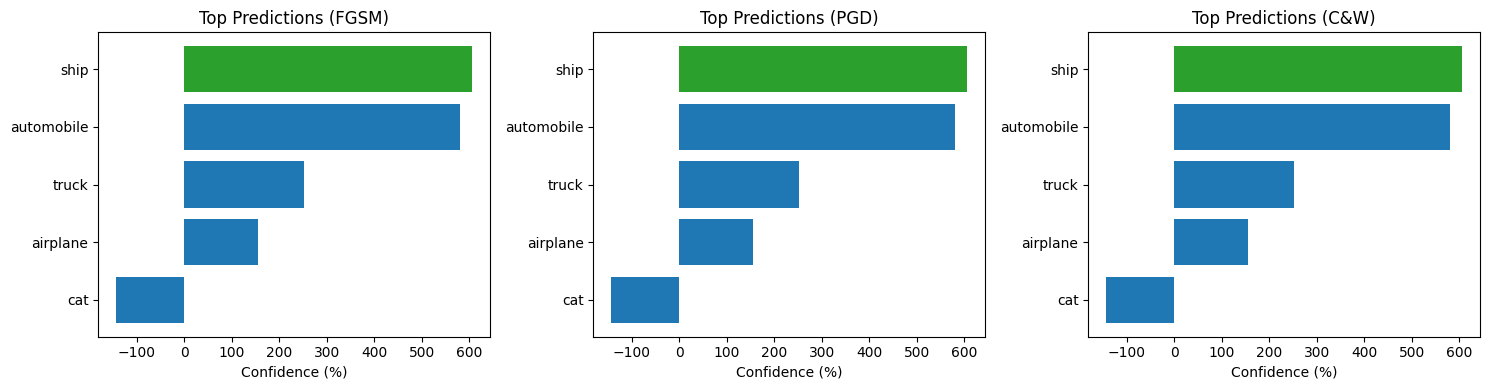

In [37]:
# Compare attacks side by side for the same sample
for idx in range(3):  # Visualize first 5 examples
    image = images[idx]
    true_label = labels[idx]

    # Dictionary to hold attack results for visualization
    attack_results = {}

    # Loop through each attack
    for attack_name, adv_examples in [
        ("FGSM", x_test_adv_fgsm_resnet20),
        ("PGD", x_test_adv_pgd_resnet20),
        ("C&W", x_test_adv_cw_resnet20)
    ]:
        # Get adversarial image and perturbation
        adv_image = adv_examples[idx]
        adv_image = torch.tensor(adv_image).to(image.device)
        perturbation = adv_image - image

        # Get model predictions for the adversarial image
        predictions = classifier_resnet.predict(image.unsqueeze(0)).squeeze()

        # Store results for the current attack
        attack_results[attack_name] = {
            "adv_image": adv_image,
            "perturbation": perturbation,
            "predictions": torch.tensor(predictions)
        }

    # Visualization: Plot results side by side
    num_attacks = len(attack_results)
    fig, axes = plt.subplots(3, num_attacks, figsize=(5 * num_attacks, 9))

    for col, (attack_name, result) in enumerate(attack_results.items()):
        # Original Image
        if col == 0:
            axes[0, col].imshow(image.cpu().permute(1, 2, 0).numpy())
            axes[0, col].set_title("Original Image\nTrue Label: " + classes[true_label])
            axes[0, col].axis("off")

        # Adversarial Image
        adv_image = result["adv_image"].cpu().permute(1, 2, 0).numpy()
        adv_image = (adv_image * np.array([0.2470, 0.2435, 0.2616])[None, None, :]) + np.array([0.4914, 0.4822, 0.4465])[None, None, :]
        adv_image = np.clip(adv_image, 0, 1)
        axes[1, col].imshow(adv_image)
        axes[1, col].set_title(f"Adversarial Image ({attack_name})")
        axes[1, col].axis("off")

        # Perturbation
        perturbation = result["perturbation"].cpu().permute(1, 2, 0).numpy()
        perturbation = (perturbation * 0.5) + 0.5  # Scale to [0, 1]
        axes[2, col].imshow(perturbation)
        axes[2, col].set_title(f"Perturbation ({attack_name})")
        axes[2, col].axis("off")

    plt.tight_layout()
    plt.show()

    # Bar Chart Comparison: Predictions for Each Attack
    fig, ax = plt.subplots(1, num_attacks, figsize=(5 * num_attacks, 4))

    for col, (attack_name, result) in enumerate(attack_results.items()):
        predictions = result["predictions"]
        topk_vals, topk_idx = torch.topk(predictions, 5)
        topk_vals, topk_idx = topk_vals.numpy(), topk_idx.numpy()

        # Bar chart for predictions
        ax[col].barh(np.arange(5), topk_vals * 100.0, align='center', color=["#1f77b4" if idx != true_label else "#2ca02c" for idx in topk_idx])
        ax[col].set_yticks(np.arange(5))
        ax[col].set_yticklabels([classes[i] for i in topk_idx])
        ax[col].invert_yaxis()
        ax[col].set_xlabel("Confidence (%)")
        ax[col].set_title(f"Top Predictions ({attack_name})")

    plt.tight_layout()
    plt.show()


**Visual Comparison:** This section shows the original image, adversarial images generated by FGSM, PGD, and C&W attacks, and their corresponding perturbations. Compare how each attack modifies the input visually.

**Prediction Comparison:** This section displays the top 3 predictions for each attack, highlighting how the model's confidence changes under adversarial conditions.

In [54]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compare_models(
    image, 
    true_label, 
    attacks, 
    vgg_classifier, 
    resnet_classifier, 
    label_names, 
    norm_mean, 
    norm_std, 
    top_k=5
):
    """
    Compares the performance of VGG16 and ResNet20 on a given image
    under clean and adversarial conditions.
    """
    num_attacks = len(attacks)  # Number of different attacks
    total_columns = num_attacks + 1  # 1 column for the clean image, +1 for each attack

    # Create 4 rows: 
    #   Row 0: Image (clean or adversarial)
    #   Row 1: Perturbation (only meaningful for adversarial attacks)
    #   Row 2: VGG16 predictions
    #   Row 3: ResNet20 predictions
    fig, axes = plt.subplots(4, total_columns, figsize=(6 * total_columns, 12), squeeze=False)

    # -------------------
    # 1. Process the clean image
    # -------------------
    clean_predictions_vgg = vgg_classifier.predict(image.unsqueeze(0)).squeeze()
    clean_predictions_resnet = resnet_classifier.predict(image.unsqueeze(0)).squeeze()

    # Denormalize the clean image for plotting
    img = image.cpu().permute(1, 2, 0).numpy()
    img = (img * np.array(norm_std)[None, None, :]) + np.array(norm_mean)[None, None, :]
    img = np.clip(img, 0.0, 1.0)

    axes[0, 0].imshow(img)
    axes[0, 0].set_title(f"Original Image\nTrue Label: {label_names[true_label]}")
    axes[0, 0].axis("off")

    # Note: row 1 in the first column can remain empty or reused,
    # because there’s no perturbation for the clean image.

    # Plot clean predictions for each model (rows 2 and 3)
    for model_idx, (model_name, predictions) in enumerate(
        [("VGG16", clean_predictions_vgg), ("ResNet20", clean_predictions_resnet)]
    ):
        topk_vals, topk_idx = torch.topk(torch.tensor(predictions), top_k)
        topk_vals, topk_idx = topk_vals.numpy(), topk_idx.numpy()

        axes[model_idx + 2, 0].barh(
            np.arange(top_k),
            topk_vals * 100.0,
            align="center",
            color=["#1f77b4" if idx != true_label else "#2ca02c" for idx in topk_idx],
        )
        axes[model_idx + 2, 0].set_yticks(np.arange(top_k))
        axes[model_idx + 2, 0].set_yticklabels([label_names[idx] for idx in topk_idx])
        axes[model_idx + 2, 0].invert_yaxis()
        axes[model_idx + 2, 0].set_xlabel("Confidence (%)")
        axes[model_idx + 2, 0].set_title(f"Clean Predictions ({model_name})")

    # -------------------
    # 2. Process each adversarial attack
    # -------------------
    for col, (attack_name, adv_examples) in enumerate(attacks.items(), start=1):
        # Convert stored numpy to torch if needed
        adv_image = torch.tensor(adv_examples).to(image.device)
        perturbation = adv_image - image

        # Get predictions from both models
        adv_predictions_vgg = vgg_classifier.predict(adv_image.unsqueeze(0)).squeeze()
        adv_predictions_resnet = resnet_classifier.predict(adv_image.unsqueeze(0)).squeeze()

        # Denormalize adversarial image for plotting
        adv_img_np = adv_image.cpu().permute(1, 2, 0).numpy()
        adv_img_np = (adv_img_np * np.array(norm_std)[None, None, :]) + np.array(norm_mean)[None, None, :]
        adv_img_np = np.clip(adv_img_np, 0.0, 1.0)

        axes[0, col].imshow(adv_img_np)
        axes[0, col].set_title(f"Adversarial Image\n({attack_name})")
        axes[0, col].axis("off")

        # Denormalize / visualize perturbation
        perturbation_np = perturbation.cpu().permute(1, 2, 0).numpy()
        # Scale to [0, 1] for a better visual of positive/negative changes
        perturbation_np = (perturbation_np * 0.5) + 0.5
        perturbation_np = np.clip(perturbation_np, 0.0, 1.0)

        axes[1, col].imshow(perturbation_np)
        axes[1, col].set_title("Perturbation")
        axes[1, col].axis("off")

        # Plot adversarial predictions for each model (rows 2 and 3)
        for model_idx, (model_name, predictions) in enumerate(
            [("VGG16", adv_predictions_vgg), ("ResNet20", adv_predictions_resnet)]
        ):
            topk_vals, topk_idx = torch.topk(torch.tensor(predictions), top_k)
            topk_vals, topk_idx = topk_vals.numpy(), topk_idx.numpy()

            axes[model_idx + 2, col].barh(
                np.arange(top_k),
                topk_vals * 100.0,
                align="center",
                color=["#1f77b4" if idx != true_label else "#2ca02c" for idx in topk_idx],
            )
            axes[model_idx + 2, col].set_yticks(np.arange(top_k))
            axes[model_idx + 2, col].set_yticklabels([label_names[idx] for idx in topk_idx])
            axes[model_idx + 2, col].invert_yaxis()
            axes[model_idx + 2, col].set_xlabel("Confidence (%)")
            axes[model_idx + 2, col].set_title(f"Predictions ({model_name})")

    plt.tight_layout()
    plt.show()




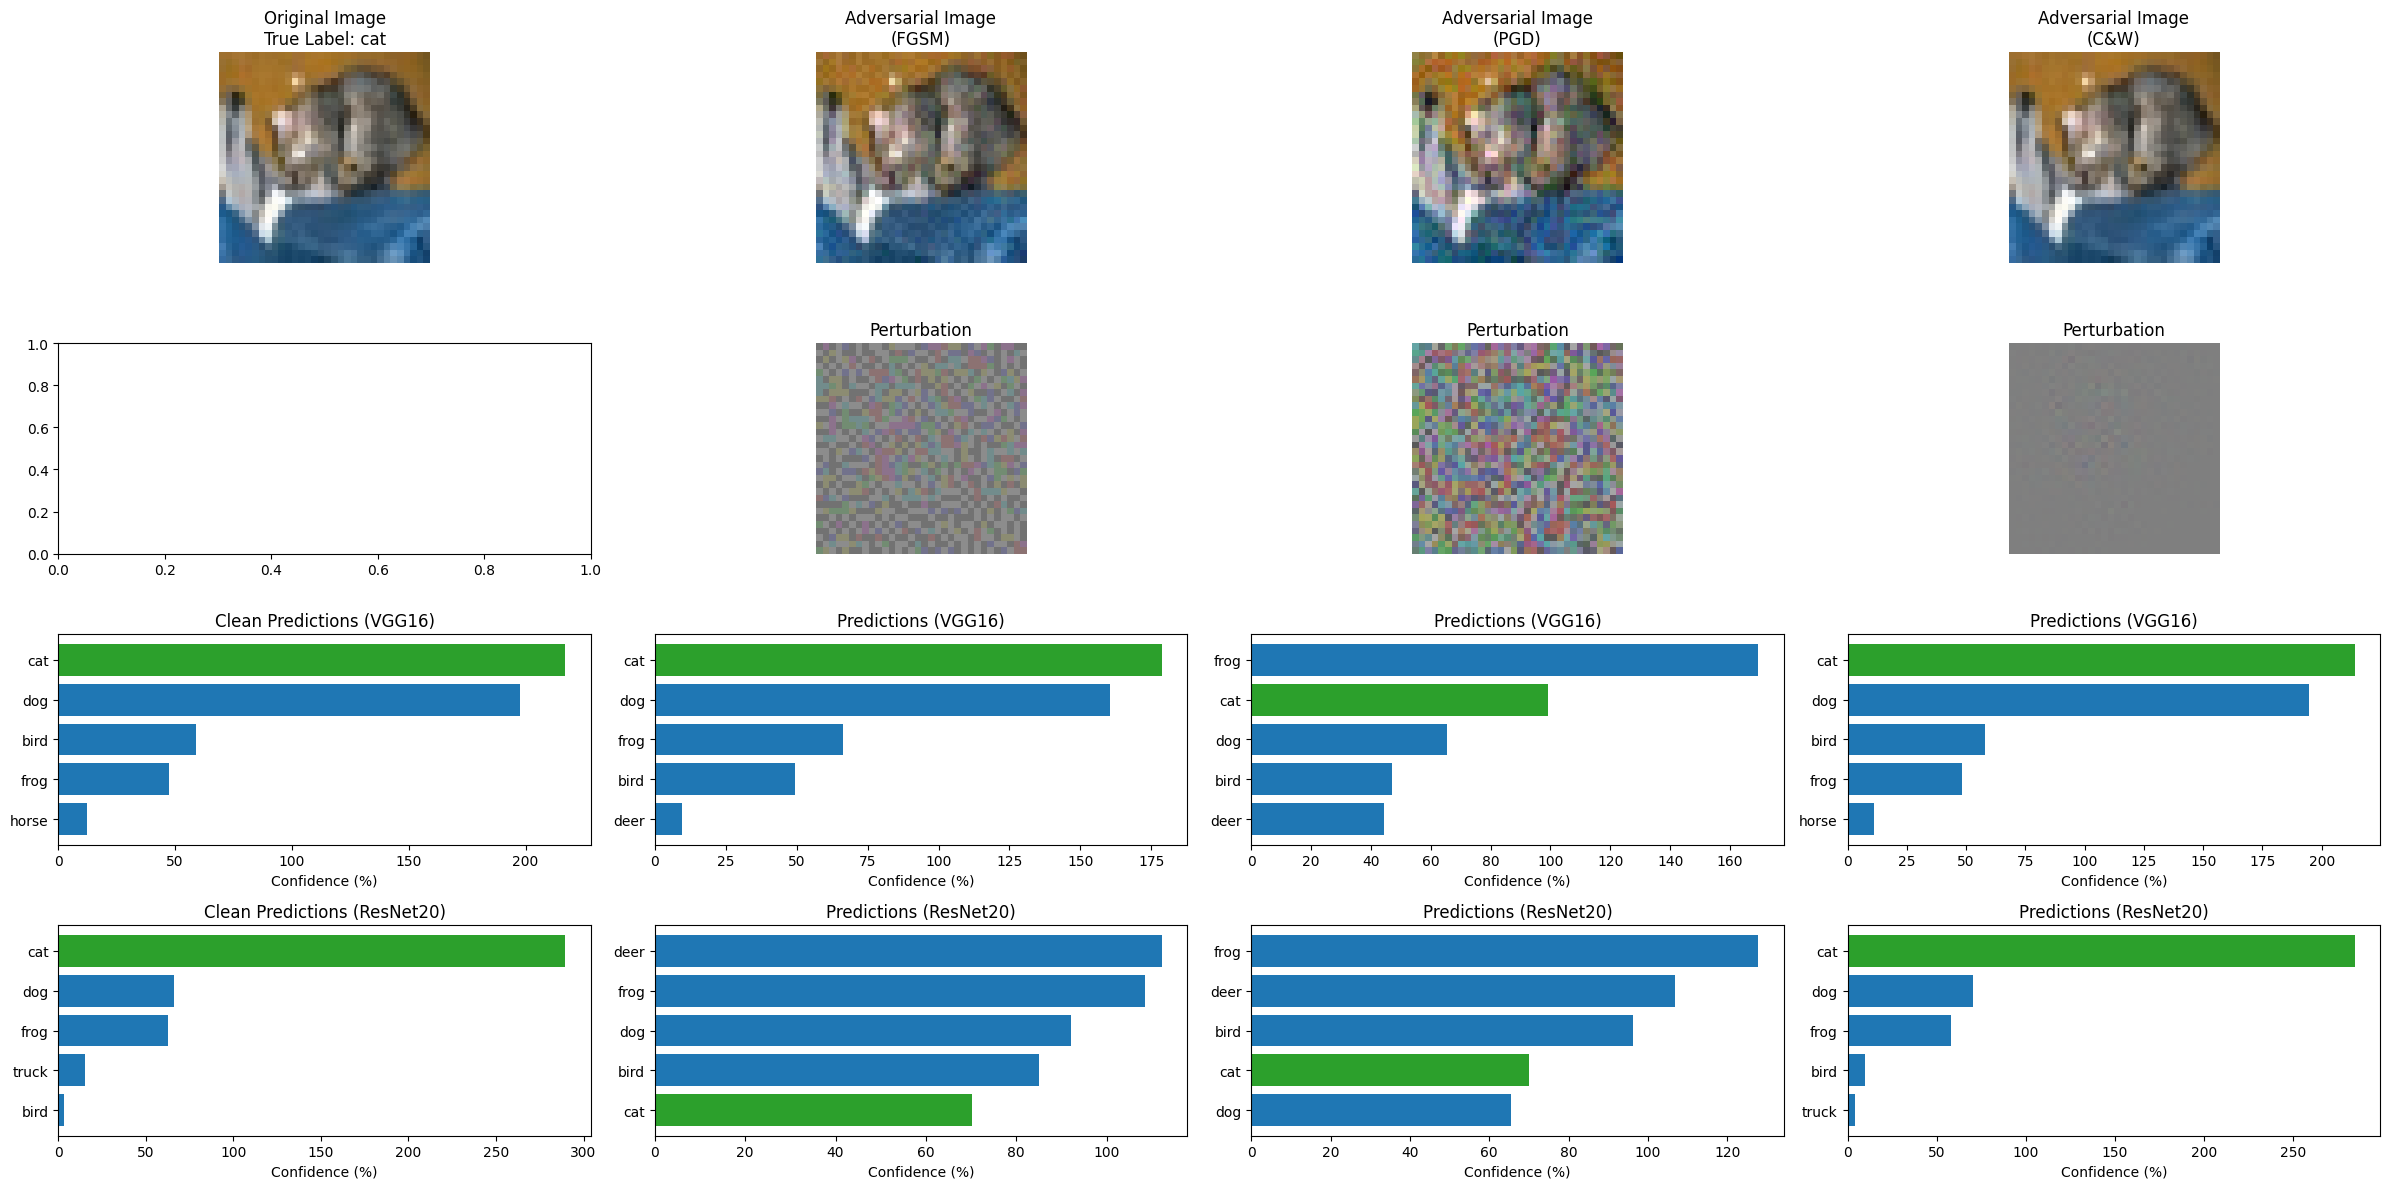

In [55]:
# Prepare attacks for a specific sample
idx = 0
attacks = {
    "FGSM": x_test_adv_fgsm_resnet20[idx],
    "PGD": x_test_adv_pgd_resnet20[idx],
    "C&W": x_test_adv_cw_resnet20[idx],
}

# Compare models
compare_models(
    image=images[idx],
    true_label=labels[idx],
    attacks=attacks,
    vgg_classifier=classifier_vgg16_bn,
    resnet_classifier=classifier_resnet,
    label_names=classes,
    norm_mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10 mean
    norm_std=[0.2470, 0.2435, 0.2616],   # CIFAR-10 std
    top_k=5
)


### implementing defensive techniques

In [8]:
from art.defences.trainer import AdversarialTrainer

# Adversarial training using FGSM, PGD, and C&W for VGG16
adv_trainer = AdversarialTrainer(classifier_vgg16_bn, attacks=[attack_fgsm_vgg16, attack_pgd_vgg16, attack_cw_vgg16])
adv_trainer.fit(images.cpu().numpy(), labels.cpu().numpy(), nb_epochs=3)

# Evaluate the robustly trained model
print("\nEvaluating adversarially trained model performance:")
acc_clean_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), images.cpu().numpy(), y_true)
print(f"Robust Model Accuracy on clean examples: {acc_clean_adv_vgg16 * 100:.2f}%")

acc_fgsm_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_fgsm_vgg16, y_true)
print(f"Robust Model Accuracy on FGSM adversarial examples: {acc_fgsm_adv_vgg16 * 100:.2f}%")

acc_pgd_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_pgd_vgg16, y_true)
print(f"Robust Model Accuracy on PGD adversarial examples: {acc_pgd_adv_vgg16 * 100:.2f}%")

acc_cw_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_cw_vgg16, y_true)
print(f"Robust Model Accuracy on C&W adversarial examples: {acc_cw_adv_vgg16 * 100:.2f}%")


Adversarial training epochs: 100%|██████████| 3/3 [5:21:39<00:00, 6433.01s/it]  



Evaluating adversarially trained model performance:
Robust Model Accuracy on clean examples: 71.80%
Robust Model Accuracy on FGSM adversarial examples: 56.70%
Robust Model Accuracy on PGD adversarial examples: 34.70%
Robust Model Accuracy on C&W adversarial examples: 71.40%


In [9]:
from art.defences.trainer import AdversarialTrainer

# Adversarial training using FGSM, PGD, and C&W for ResNet20
adv_trainer = AdversarialTrainer(classifier_resnet, attacks=[attack_fgsm_resnet20, attack_pgd_resnet20, attack_cw_resnet20])
adv_trainer.fit(images.cpu().numpy(), labels.cpu().numpy(), nb_epochs=3)

# Evaluate the robustly trained model
print("\nEvaluating adversarially trained model performance:")
acc_clean_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), images.cpu().numpy(), y_true)
print(f"Robust Model Accuracy on clean examples: {acc_clean_adv_resnet20 * 100:.2f}%")

acc_fgsm_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_fgsm_resnet20, y_true)
print(f"Robust Model Accuracy on FGSM adversarial examples: {acc_fgsm_adv_resnet20 * 100:.2f}%")

acc_pgd_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_pgd_resnet20, y_true)
print(f"Robust Model Accuracy on PGD adversarial examples: {acc_pgd_adv_resnet20 * 100:.2f}%")

acc_cw_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_cw_resnet20, y_true)
print(f"Robust Model Accuracy on C&W adversarial examples: {acc_cw_adv_resnet20 * 100:.2f}%")


Adversarial training epochs: 100%|██████████| 3/3 [3:37:20<00:00, 4346.73s/it]  



Evaluating adversarially trained model performance:
Robust Model Accuracy on clean examples: 57.40%
Robust Model Accuracy on FGSM adversarial examples: 44.10%
Robust Model Accuracy on PGD adversarial examples: 22.50%
Robust Model Accuracy on C&W adversarial examples: 56.20%


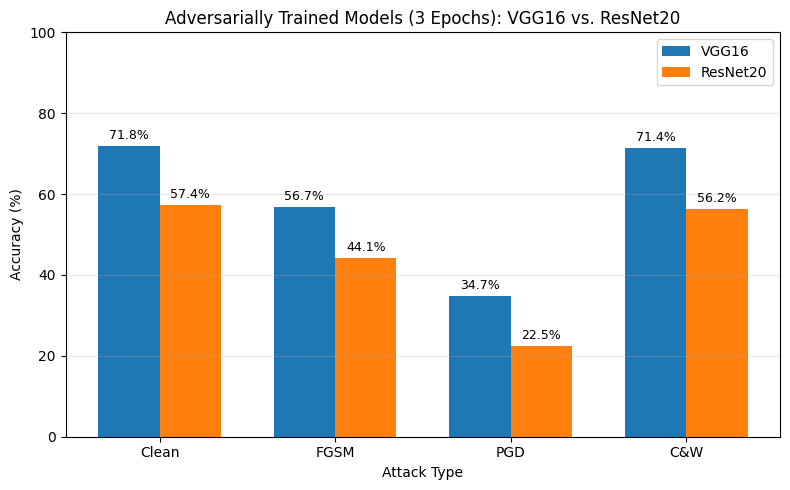

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# The methods or "conditions" under which accuracy was measured
methods = ["Clean", "FGSM", "PGD", "C&W"]

# Put your final accuracies (in %) into lists:
vgg_accuracies = [71.80, 56.70, 34.70, 71.40]
resnet_accuracies = [57.40, 44.10, 22.50, 56.20]

# We'll make a grouped bar chart
bar_width = 0.35
x = np.arange(len(methods))  # e.g., [0,1,2,3]

plt.figure(figsize=(8,5))

# Plot VGG16 bars
plt.bar(x - bar_width/2, vgg_accuracies, width=bar_width, label='VGG16')
# Plot ResNet20 bars
plt.bar(x + bar_width/2, resnet_accuracies, width=bar_width, label='ResNet20')

# Optionally add data labels above each bar
for i, val in enumerate(vgg_accuracies):
    plt.text(i - bar_width/2, val + 1, f"{val:.1f}%", 
             ha='center', va='bottom', fontsize=9)
for i, val in enumerate(resnet_accuracies):
    plt.text(i + bar_width/2, val + 1, f"{val:.1f}%",
             ha='center', va='bottom', fontsize=9)

# Customizing plot axes/labels
plt.xticks(x, methods)
plt.ylim([0, 100])  # Because accuracy is in [0,100]
plt.xlabel("Attack Type")
plt.ylabel("Accuracy (%)")
plt.title("Adversarially Trained Models (3 Epochs): VGG16 vs. ResNet20")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
